<h1> Importing Drive Datasets </h1>

In [ ]:
!git clone https://github.com/flori-margaritescu/human-judgements-honours.git

Cloning into 'human-judgements-honours'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 2), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), 4.34 KiB | 2.17 MiB/s, done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/distortion_triplets.zip" -d "/content/datasets/distortions"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/hsj_triplets.zip" -d "/content/datasets/hsj"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/birds_dataset_triplets.zip" -d "/content/datasets/birds-16"

### Imports

In [ ]:
!pip install img2vec-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from PIL import Image
import os

from img2vec_pytorch import Img2Vec

### Testing

Note: AlexNet and ResNet-18 take in completely different Tensor formats!

<h2> Note: the below package does the feature extraction for us aparently - careful with how you use it - better start from scratch for consistency of results!</h2>

In [ ]:
# Initialize Img2Vec with GPU
img2vec_alexnet = Img2Vec(cuda=False, model="alexnet")  # default model resnet

# Read in an image (rgb format)
img = Image.open('test.png').convert('RGB')

# Get a vector from img2vec, returned as a torch FloatTensor
vec = img2vec_alexnet.get_vec(img, tensor=True)

print(vec.size())

# Initialize Img2Vec with GPU
img2vec_18 = Img2Vec(cuda=False, model="resnet-18")  # default model resnet

# Read in an image (rgb format)
img = Image.open('test.png').convert('RGB')
# Get a vector from img2vec, returned as a torch FloatTensor
vec = img2vec_18.get_vec(img, tensor=True)  

print(vec.size())

torch.Size([1, 4096])
torch.Size([1, 512, 1, 1])


In [ ]:
ref = Image.open('ref.png').convert('RGB')
ref_vec = img2vec.get_vec(ref, tensor=True)

p0 = Image.open('p0.png').convert('RGB')
p0_vec = img2vec.get_vec(p0, tensor=True)

p1 = Image.open('p1.png').convert('RGB')
p1_vec = img2vec.get_vec(p1, tensor=True)

NameError: ignored

In [ ]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(ref_vec,
              p0_vec)
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: tensor([0.4113])



In [ ]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(ref_vec,
              p1_vec)
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: tensor([0.3291])



### Common functions for loading dataset

In [ ]:
def format_image_number(number):
    img_no_str = str(number)
    
    if len(img_no_str) == 1:
        im_no_name = "00000"
    elif len(img_no_str) == 2:
        im_no_name = "0000"
    elif len(img_no_str) == 3:
        im_no_name = "000"
    elif len(img_no_str) == 4:
        im_no_name = "00"
    elif len(img_no_str) == 5:
        im_no_name = "0"
    elif len(img_no_str) == 6:
        im_no_name = ""
        
    return im_no_name + img_no_str
    

def get_images_vector(path, number_of_images):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_list = []
    
    for image_no in range(number_of_images):
        image_no_str = str(image_no)
        
        im_no_name = format_image_number(image_no_str) + ".png"
        
        path_to_image = path + im_no_name

        feature_vector_image = Image.open(path_to_image).convert('RGB')
        feature_vec = img2vec.get_vec(feature_vector_image, tensor=True)
        feature_tensor_list.append(feature_vec)
        
    return feature_tensor_list

In [ ]:
def obtain_cosine_similarity_model_predictions(number_of_images, refs_vec_list, p0s_rec_list, p1s_rec_list):
    cosine_similarity_ref_and_p0 = []
    cosine_similarity_ref_and_p1 = []

    # list of predictions
    cosine_similarity_predictions = []
    
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

    for image_no in range(number_of_images): 
        reshaped_ref = torch.reshape(refs_vec_list[image_no], (1,512))
        reshaped_p0 = torch.reshape(p0s_rec_list[image_no], (1,512))
        reshaped_p1 = torch.reshape(p1s_rec_list[image_no], (1,512))
        
        cosine_similarity_ref_and_p0.append(cos(reshaped_ref, reshaped_p0))
        cosine_similarity_ref_and_p1.append(cos(reshaped_ref, reshaped_p1))

        if cosine_similarity_ref_and_p0[image_no] >= cosine_similarity_ref_and_p1[image_no]:
            cosine_similarity_predictions.append(0)
        else:
            cosine_similarity_predictions.append(1)   
            
    return cosine_similarity_predictions

In [ ]:
def obtain_prediction_accuracy(number_of_images, path_to_decision, actual_predictions):
    expected_decision_outputs = []

    for image_no in range(number_of_images):
            image_no_str = str(image_no)

            im_no_name = format_image_number(image_no_str) + ".npy"
            path_to_image = path_to_decision + im_no_name

            decision = np.load(path_to_image)

            if decision[0] <= 0.5: 
                expected_decision_outputs.append(0)
            else: 
                expected_decision_outputs.append(1)
                
    number_wrong_predictions = 0

    for image_no in range(number_of_images):
        if actual_predictions[image_no] != expected_decision_outputs[image_no]:
            number_wrong_predictions += 1

    accuracy = (number_of_images - number_wrong_predictions)/(number_of_images)
    
    return accuracy


In [ ]:
def reshape_tensor_list(dim, tensor_list):
    reshaped_list = []
    for t in tensor_list:
        reshaped_t = torch.reshape(t, (1,dim))
        reshaped_list.append(t)
    return reshaped_list

### 1. Resnet

In [ ]:
img2vec_res = Img2Vec(cuda=False, model="resnet-18")  # default model resnet

#### 1.1 Traditional

In [ ]:
traditional_refs = get_images_vector("val/traditional/ref/", 4720)
traditional_p0s = get_images_vector("val/traditional/p0/", 4720)
traditional_p1s = get_images_vector("val/traditional/p1/", 4720)

In [ ]:
print(len(traditional_refs))
print(len(traditional_p0s))
print(len(traditional_p1s))

4720
4720
4720


In [ ]:
actual_model_predictions = obtain_cosine_similarity_model_predictions(4720, traditional_refs, traditional_p0s, traditional_p1s)

In [ ]:
prediction_accuracy = obtain_prediction_accuracy(4720, "val/traditional/judge/", actual_model_predictions)

In [ ]:
prediction_accuracy

0.8048728813559322

Prediction accuracy for Resnet-18 for traditional distortions: 0.8048728813559322

#### 1.2 CNN-based

In [ ]:
cnn_refs = get_images_vector("val/cnn/ref/", 4720)
cnn_p0s = get_images_vector("val/cnn/p0/", 4720)
cnn_p1s = get_images_vector("val/cnn/p1/", 4720)

In [ ]:
print(len(cnn_refs))
print(len(cnn_p0s))
print(len(cnn_p1s))

4720
4720
4720


In [ ]:
actual_model_predictions_cnn_distortion = obtain_cosine_similarity_model_predictions(4720, cnn_refs, cnn_p0s, cnn_p1s)

In [ ]:
prediction_accuracy_cnn_distortion = obtain_prediction_accuracy(4720, "val/cnn/judge/", actual_model_predictions_cnn_distortion)

In [ ]:
prediction_accuracy_cnn_distortion

0.8442796610169492

Prediction accuracy for Resnet-18 for CNN-based distortions: 0.8442796610169492

#### 1.3 Colorization

In [ ]:
color_refs = get_images_vector("val/color/ref/", 4720)
color_p0s = get_images_vector("val/color/p0/", 4720)
color_p1s = get_images_vector("val/color/p1/", 4720)

In [ ]:
print(len(color_refs))
print(len(color_p0s))
print(len(color_p1s))

4720
4720
4720


In [ ]:
actual_model_predictions_color_distortion = obtain_cosine_similarity_model_predictions(4720, color_refs, color_p0s, color_p1s)

In [ ]:
prediction_accuracy_color_distortion = obtain_prediction_accuracy(4720, "val/color/judge/", actual_model_predictions_color_distortion)

In [ ]:
prediction_accuracy_color_distortion

0.6533898305084745

Prediction accuracy for Resnet-18 for colorizaton distortions: 0.6533898305084745

#### 1.4 Deblurring --- IGNORE FOR NOW

In [ ]:
deb_refs = get_images_vector("val/deblur/ref/", 9440)
deb_p0s = get_images_vector("val/deblur/p0/", 9440)
deb_p1s = get_images_vector("val/deblur/p1/", 9440)

fi_refs = get_images_vector("val/frameinterp/ref/", 1888)
fi_p0s = get_images_vector("val/frameinterp/p0/", 1888)
fi_p1s = get_images_vector("val/frameinterp/p1/", 1888)

In [ ]:
print(len(deb_refs))
print(len(deb_p0s))
print(len(deb_p1s))

4720
4720
4720


In [ ]:
actual_model_predictions_deb_distortion = obtain_cosine_similarity_model_predictions(4720, deb_refs, deb_p0s, deb_p1s)

In [ ]:
prediction_accuracy_deb_distortion = obtain_prediction_accuracy(4720, "val/deblur/judge/", actual_model_predictions_deb_distortion)

In [ ]:
prediction_accuracy_deb_distortion

0.6016949152542372

Prediction accuracy for Resnet-18 for deblurring distortions: 0.6016949152542372

#### 1.4, 1.5 and 1.6 Deblurring, frame interpolation and super resolution

In [ ]:
deblur_refs = get_images_vector("val/deblur/ref/", 9440)
deblur_p0s = get_images_vector("val/deblur/p0/", 9440)
deblur_p1s = get_images_vector("val/deblur/p1/", 9440)
print("Deblurring is complete")

fi_refs = get_images_vector("val/frameinterp/ref/", 1888)
fi_p0s = get_images_vector("val/frameinterp/p0/", 1888)
fi_p1s = get_images_vector("val/frameinterp/p1/", 1888)
print("FI is complete")

spr_refs = get_images_vector("val/superres/ref/", 10856)
spr_p0s = get_images_vector("val/superres/p0/", 10856)
spr_p1s = get_images_vector("val/superres/p1/", 10856)
print("Spr is complete")

Deblurring is complete
FI is complete
Spr is complete


In [ ]:
actual_model_predictions_blur_distortion = obtain_cosine_similarity_model_predictions(9440, deblur_refs, deblur_p0s, deblur_p1s)
prediction_accuracy_blur_distortion = obtain_prediction_accuracy(9440, "val/deblur/judge/", actual_model_predictions_blur_distortion)
print("Deblur: ")
print(prediction_accuracy_blur_distortion)
print("----------------")
print("")
print("")

Deblur: 
0.6113347457627119
----------------




In [ ]:
actual_model_predictions_frame = obtain_cosine_similarity_model_predictions(1888, fi_refs, fi_p0s, fi_p1s)
prediction_accuracy_frame = obtain_prediction_accuracy(1888, "val/frameinterp/judge/", actual_model_predictions_frame)
print("Fi: ")
print(prediction_accuracy_frame)
print("----------------")
print("")
print("")

Fi: 
0.6604872881355932
----------------




In [ ]:
actual_model_predictions_cnn_distortion_super = obtain_cosine_similarity_model_predictions(10856, spr_refs, spr_p0s, spr_p1s)
prediction_accuracy_cnn_distortion_super = obtain_prediction_accuracy(10856, "val/superres/judge/", actual_model_predictions_cnn_distortion_super)
print("Spr: ")
print(prediction_accuracy_cnn_distortion_super)
print("----------------")
print("")
print("")

Spr: 
0.7198784082535004
----------------




Prediction accuracy for Resnet-18 for deblurring distortions: 0.6113347457627119

Prediction accuracy for Resnet-18 for frame interpolation distortions: 0.6604872881355932

Prediction accuracy for Resnet-18 for super resolution distortions: 0.7198784082535004

### 2. AlexNet

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from PIL import Image
import os

from img2vec_pytorch import Img2Vec

def format_image_number(number):
    img_no_str = str(number)
    
    if len(img_no_str) == 1:
        im_no_name = "00000"
    elif len(img_no_str) == 2:
        im_no_name = "0000"
    elif len(img_no_str) == 3:
        im_no_name = "000"
    elif len(img_no_str) == 4:
        im_no_name = "00"
    elif len(img_no_str) == 5:
        im_no_name = "0"
    elif len(img_no_str) == 6:
        im_no_name = ""
        
    return im_no_name + img_no_str
    
img2vec = Img2Vec(cuda=False, model="alexnet")  # default model resnet

def get_images_vector(path, number_of_images):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_list = []
    
    for image_no in range(number_of_images):
        image_no_str = str(image_no)
        
        im_no_name = format_image_number(image_no_str) + ".png"
        
        path_to_image = path + im_no_name

        feature_vector_image = Image.open(path_to_image).convert('RGB')
        feature_vec = img2vec.get_vec(feature_vector_image, tensor=True)
        feature_tensor_list.append(feature_vec)
        
    return feature_tensor_list

def obtain_cosine_similarity_model_predictions(number_of_images, refs_vec_list, p0s_rec_list, p1s_rec_list):
    cosine_similarity_ref_and_p0 = []
    cosine_similarity_ref_and_p1 = []

    # list of predictions
    cosine_similarity_predictions = []
    
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

    for image_no in range(number_of_images): 
        reshaped_ref = refs_vec_list[image_no]
        reshaped_p0 = p0s_rec_list[image_no]
        reshaped_p1 = p1s_rec_list[image_no]
        
        cosine_similarity_ref_and_p0.append(cos(reshaped_ref, reshaped_p0))
        cosine_similarity_ref_and_p1.append(cos(reshaped_ref, reshaped_p1))

        if cosine_similarity_ref_and_p0[image_no] >= cosine_similarity_ref_and_p1[image_no]:
            cosine_similarity_predictions.append(0)
        else:
            cosine_similarity_predictions.append(1)   
            
    return cosine_similarity_predictions

def obtain_prediction_accuracy(number_of_images, path_to_decision, actual_predictions):
    expected_decision_outputs = []

    for image_no in range(number_of_images):
            image_no_str = str(image_no)

            im_no_name = format_image_number(image_no_str) + ".npy"
            path_to_image = path_to_decision + im_no_name

            decision = np.load(path_to_image)

            if decision[0] <= 0.5: 
                expected_decision_outputs.append(0)
            else: 
                expected_decision_outputs.append(1)
                
    number_wrong_predictions = 0

    for image_no in range(number_of_images):
        if actual_predictions[image_no] != expected_decision_outputs[image_no]:
            number_wrong_predictions += 1

    accuracy = (number_of_images - number_wrong_predictions)/(number_of_images)
    
    return accuracy


def reshape_tensor_list(dim, tensor_list):
    reshaped_list = []
    for t in tensor_list:
        reshaped_t = torch.reshape(t, (1,dim))
        reshaped_list.append(t)
    return reshaped_list



print("Alexnet results:")

img2vec_res = Img2Vec(cuda=False, model="alexnet")  # default model resnet

traditional_refs = get_images_vector("val/traditional/ref/", 4720)
traditional_p0s = get_images_vector("val/traditional/p0/", 4720)
traditional_p1s = get_images_vector("val/traditional/p1/", 4720)

cnn_refs = get_images_vector("val/cnn/ref/", 4720)
cnn_p0s = get_images_vector("val/cnn/p0/", 4720)
cnn_p1s = get_images_vector("val/cnn/p1/", 4720)

color_refs = get_images_vector("val/color/ref/", 4720)
color_p0s = get_images_vector("val/color/p0/", 4720)
color_p1s = get_images_vector("val/color/p1/", 4720)

deblur_refs = get_images_vector("val/deblur/ref/", 9440)
deblur_p0s = get_images_vector("val/deblur/p0/", 9440)
deblur_p1s = get_images_vector("val/deblur/p1/", 9440)
print("Deblurring is complete")

fi_refs = get_images_vector("val/frameinterp/ref/", 1888)
fi_p0s = get_images_vector("val/frameinterp/p0/", 1888)
fi_p1s = get_images_vector("val/frameinterp/p1/", 1888)
print("FI is complete")

spr_refs = get_images_vector("val/superres/ref/", 10856)
spr_p0s = get_images_vector("val/superres/p0/", 10856)
spr_p1s = get_images_vector("val/superres/p1/", 10856)
print("Spr is complete")


actual_model_predictions = obtain_cosine_similarity_model_predictions(4720, traditional_refs, traditional_p0s, traditional_p1s)
prediction_accuracy = obtain_prediction_accuracy(4720, "val/traditional/judge/", actual_model_predictions)
print("Traditional: ")
print(prediction_accuracy)
print("----------------")
print("")
print("")

actual_model_predictions_cnn_distortion = obtain_cosine_similarity_model_predictions(4720, cnn_refs, cnn_p0s, cnn_p1s)
prediction_accuracy_cnn_distortion = obtain_prediction_accuracy(4720, "val/cnn/judge/", actual_model_predictions_cnn_distortion)
print("CNN: ")
print(prediction_accuracy_cnn_distortion)
print("----------------")
print("")
print("")


actual_model_predictions_color_distortion = obtain_cosine_similarity_model_predictions(4720, color_refs, color_p0s, color_p1s)
prediction_accuracy_color_distortion = obtain_prediction_accuracy(4720, "val/color/judge/", actual_model_predictions_color_distortion)
print("Colorization: ")
print(prediction_accuracy_color_distortion)
print("----------------")
print("")
print("")

actual_model_predictions_blur_distortion = obtain_cosine_similarity_model_predictions(9440, deblur_refs, deblur_p0s, deblur_p1s)
prediction_accuracy_blur_distortion = obtain_prediction_accuracy(9440, "val/deblur/judge/", actual_model_predictions_blur_distortion)
print("Deblur: ")
print(prediction_accuracy_blur_distortion)
print("----------------")
print("")
print("")


actual_model_predictions_frame = obtain_cosine_similarity_model_predictions(1888, fi_refs, fi_p0s, fi_p1s)
prediction_accuracy_frame = obtain_prediction_accuracy(1888, "val/frameinterp/judge/", actual_model_predictions_frame)
print("Fi: ")
print(prediction_accuracy_frame)
print("----------------")
print("")
print("")

actual_model_predictions_cnn_distortion_super = obtain_cosine_similarity_model_predictions(10856, spr_refs, spr_p0s, spr_p1s)
prediction_accuracy_cnn_distortion_super = obtain_prediction_accuracy(10856, "val/superres/judge/", actual_model_predictions_cnn_distortion_super)
print("Spr: ")
print(prediction_accuracy_cnn_distortion_super)
print("----------------")
print("")
print("")

Alexnet results:
Deblurring is complete
FI is complete
Spr is complete
Traditional: 
0.8108050847457627
----------------


CNN: 
0.8544491525423729
----------------


Colorization: 
0.6720338983050848
----------------


Deblur: 
0.639406779661017
----------------


Fi: 
0.666843220338983
----------------


Spr: 
0.7424465733235077
----------------




AlexNet: 
    
Traditional: 
0.8108050847457627


CNN: 
0.8544491525423729



Colorization: 
0.6720338983050848



Deblur: 
0.639406779661017



Fi: 
0.666843220338983



Spr: 
0.7424465733235077

<h1> NEW START HERE </h1>

Link: https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
 + modify to adhere to current PyTorch updates

*What we have done here is created a reference to the layer we want to extract from. Deciding on which layer to extract from is a bit of a science, but something to keep in mind is that early layers in the network are usually learning high-level features such as ‘image contains fur’ or ‘image contains round object’, while lower-level features are more specific to the training data. The ‘avgpool’ layer selected here is at the end of ResNet-18, but if you plan to use images that are very different from ImageNet, you may benefit in using an ealier layer or fine-tuning the model.*

Conclusion for me: because later layers are more specific to training data THEN I am expecting all models to perform much better on HSJ and the worst on Distortions.


**But if you plan to use images that are very different from ImageNet, you may benefit in using an ealier layer or fine-tuning the model.**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image

In [ ]:
# Load the pretrained model
model = models.resnet18(pretrained=True)
model.cuda()
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')
# Set model to evaluation mode
model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Set model to evaluation mode
model.eval()

In [ ]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()   # used to convert the PIL image to a PyTorch tensor (multidimensional array)

In [ ]:
def get_vector(image_name):
    
#     # Load the pretrained model
#     model = models.resnet18(pretrained=True)
#     # Use the model object to select the desired layer
#     layer = model._modules.get('avgpool')
    
    # 1. Load the image with Pillow library
    img = Image.open(image_name).convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).cuda()
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    
    # M1: my_embedding = torch.zeros(1, 512, 1, 1) and later my_embedding.copy_(o.data)
    # M2: my_embedding = torch.zeros(512) and later my_embedding.copy_(o.data.reshape(o.data.size(1)))
    my_embedding = torch.zeros(512).cuda()
    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

In [ ]:
query_vector = get_vector("ref.png")
ref1_vector = get_vector("p0.png")
ref2_vector = get_vector("p1.png")

In [ ]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(query_vector.unsqueeze(0),
              ref1_vector.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: tensor([0.8143], device='cuda:0')



In [ ]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(query_vector.unsqueeze(0),
              ref2_vector.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: tensor([0.5251], device='cuda:0')



In [ ]:
def get_image_embeddings(path, image_type):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_dict = dict()
    feature_tensor_dict["ref"] = []
    feature_tensor_dict["p0"] = []
    feature_tensor_dict["p1"] = []
    feature_tensor_dict["decision"] = []
    
    for image_no in range(1000):
        im_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + "." + image_type
        
        feature_tensor_dict["ref"].append(get_vector(path+"/ref/" + im_no_name))
        feature_tensor_dict["p0"].append(get_vector(path+"/p0/" + im_no_name))
        feature_tensor_dict["p1"].append(get_vector(path+"/p1/" + im_no_name))

        # now load decision
        decision_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + ".npy"
        decision = np.load(path+"/judge/"+decision_no_name)
        if decision[0] <= 0.5: 
              feature_tensor_dict["decision"].append(0)
        else: 
              feature_tensor_dict["decision"].append(1)
        
    return feature_tensor_dict

In [ ]:
%cd /content

/content


In [ ]:
resnet_18_embedddings = get_image_embeddings("datasets/distortions/distortion_triplets/traditional_triplets", "png")

In [ ]:
resnet_18_embedddings["decision"]

In [ ]:
def get_predictions(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

  for image_no in range(1000):
      cosine_similarity_dict["ref_and_p0"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0)))
      cosine_similarity_dict["ref_and_p1"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0)))
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions

def get_accuracy(predictions,embeddings):
  decisions = embeddings["decision"]

  number_wrong_predictions = 0

  for image_no in range(1000):
      if predictions[image_no] != decisions[image_no]:
          number_wrong_predictions += 1
      
  accuracy = (1000 - number_wrong_predictions)/(1000)
  return accuracy

In [ ]:
predictions = get_predictions(resnet_18_embedddings)
accuracy = get_accuracy(predictions, resnet_18_embedddings)

In [ ]:
accuracy

0.809

<h1> Loading dataset and drive </h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install img2vec-pytorch

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/distortion_triplets.zip" -d "/content/datasets/distortions"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/hsj_triplets.zip" -d "/content/datasets/hsj"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/birds_dataset_triplets.zip" -d "/content/datasets/birds-16"

<h1> Working framework start </h1>

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np

from PIL import Image

############################ REQUIRES MODIFICATION FOR EACH MODEL 

# scaler = transforms.Resize((224, 224))
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()   # used to convert the PIL image to a PyTorch tensor (multidimensional array)
############################


############################## HOW TO GET MODEL:
# # Load the pretrained model
# model = models.resnet18(pretrained=True)
# model.cuda()
# # Use the model object to select the desired layer
# layer = model._modules.get('avgpool')
# # Set model to evaluation mode
# model.eval()

##################################

def get_vector(image_name, model, layer, scaler, normalize, feature_tensor_size):
    
#     # Load the pretrained model
#     model = models.resnet18(pretrained=True)
#     # Use the model object to select the desired layer
#     layer = model._modules.get('avgpool')
    
    # 1. Load the image with Pillow library
    img = Image.open(image_name).convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).cuda()
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    
    # M1: my_embedding = torch.zeros(1, 512, 1, 1) and later my_embedding.copy_(o.data)
    # M2: my_embedding = torch.zeros(512) and later my_embedding.copy_(o.data.reshape(o.data.size(1)))
    my_embedding = torch.zeros(feature_tensor_size).cuda()
    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding
    

############################ COSINE SIMILARITY
cos = nn.CosineSimilarity(dim=1, eps=1e-6)


########################### GET FEATURE VECTORS
def get_image_embeddings(path, image_type, model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_dict = dict()
    feature_tensor_dict["ref"] = []
    feature_tensor_dict["p0"] = []
    feature_tensor_dict["p1"] = []
    feature_tensor_dict["decision"] = []
    
    for image_no in range(1000):
        im_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + "." + image_type
        
        feature_tensor_dict["ref"].append(get_vector(path+"/ref/" + im_no_name, model, layer, scaler, normalize, feature_tensor_size))
        feature_tensor_dict["p0"].append(get_vector(path+"/p0/" + im_no_name, model, layer, scaler, normalize, feature_tensor_size))
        feature_tensor_dict["p1"].append(get_vector(path+"/p1/" + im_no_name, model, layer, scaler, normalize, feature_tensor_size))

        # now load decision
        if isHSJOrBirds:
          feature_tensor_dict["decision"].append(0)
        else: 
          decision_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + ".npy"
          decision = np.load(path+"/judge/"+decision_no_name)
          if decision[0] <= 0.5: 
                feature_tensor_dict["decision"].append(0)
          else: 
                feature_tensor_dict["decision"].append(1)
        
    return feature_tensor_dict


########################## GET MODEL PREDICTIONS
def get_predictions(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

  for image_no in range(1000):
      cosine_similarity_dict["ref_and_p0"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0)))
      cosine_similarity_dict["ref_and_p1"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0)))
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions

########################## GET MODEL ACCURACY
def get_accuracy(predictions,embeddings):
  decisions = embeddings["decision"]

  number_wrong_predictions = 0

  for image_no in range(1000):
      if predictions[image_no] != decisions[image_no]:
          number_wrong_predictions += 1
      
  accuracy = (1000 - number_wrong_predictions)/(1000)
  return accuracy


def apply_framework(path, image_type, model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size):
  embeddings = get_image_embeddings(path, 
                                    image_type,
                                    model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size)
  predictions= get_predictions(embeddings)
  accuracy = get_accuracy(predictions, embeddings)
  print(path + ": " + str(accuracy))
  return accuracy

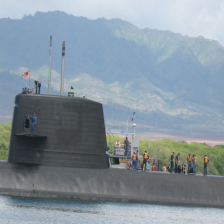

In [ ]:
    # 1. Load the image with Pillow library
img = Image.open("datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar/p0/000000.jpg").convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
scaler = transforms.Resize((224, 224))
t_img = scaler(img)
t_img

1. Resnet-18 + cosine similarity

datasets/distortions/distortion_triplets/traditional_triplets: 0.809

datasets/distortions/distortion_triplets/cnn_triplets: 0.848

datasets/distortions/distortion_triplets/color_triplets: 0.623

datasets/distortions/distortion_triplets/deblur_triplets: 0.603

datasets/distortions/distortion_triplets/frameinterp_triplets: 0.663

datasets/distortions/distortion_triplets/superres_triplets: 0.723

In [ ]:
# Load the pretrained model
model = models.resnet18(pretrained=True)
model.cuda()
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')
# Set model to evaluation mode
model.eval()
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

print("# ----------------------------------------BAPPS 2AFC DIST RESNET-18------------------------#")
print("")
################### TRADITIONAL 
apply_framework("datasets/distortions/distortion_triplets/traditional_triplets",
                "png",
                model, layer, scaler, normalize, False)

################ CNN
apply_framework("datasets/distortions/distortion_triplets/cnn_triplets",
                "png",
                model, layer, scaler, normalize, False)

############### COLOR
apply_framework("datasets/distortions/distortion_triplets/color_triplets",
                "png",
                model, layer, scaler, normalize, False)

################ DEBLUR
apply_framework("datasets/distortions/distortion_triplets/deblur_triplets",
                "png",
                model, layer, scaler, normalize, False)

############### FRAME INTERP
apply_framework("datasets/distortions/distortion_triplets/frameinterp_triplets",
                "png",
                model, layer, scaler, normalize, False)

################ SUPER RES
apply_framework("datasets/distortions/distortion_triplets/superres_triplets",
                "png",
                model, layer, scaler, normalize, False)

# datasets/distortions/distortion_triplets/traditional_triplets: 0.809
# datasets/distortions/distortion_triplets/cnn_triplets: 0.848
# datasets/distortions/distortion_triplets/color_triplets: 0.623
# datasets/distortions/distortion_triplets/deblur_triplets: 0.603
# datasets/distortions/distortion_triplets/frameinterp_triplets: 0.663
# datasets/distortions/distortion_triplets/superres_triplets: 0.723

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# ----------------------------------------BAPPS 2AFC DIST RESNET-18------------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.809
datasets/distortions/distortion_triplets/cnn_triplets: 0.848
datasets/distortions/distortion_triplets/color_triplets: 0.623
datasets/distortions/distortion_triplets/deblur_triplets: 0.603
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.663
datasets/distortions/distortion_triplets/superres_triplets: 0.723


0.723

###BAPPS 2AFC DIST RESNET-18+Cosine Similarity

datasets/distortions/distortion_triplets/traditional_triplets: 0.809

datasets/distortions/distortion_triplets/cnn_triplets: 0.848

datasets/distortions/distortion_triplets/color_triplets: 0.623

datasets/distortions/distortion_triplets/deblur_triplets: 0.603

datasets/distortions/distortion_triplets/frameinterp_triplets: 0.663

datasets/distortions/distortion_triplets/superres_triplets: 0.723


----------------------------------------HSJ------------------------

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.695

datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.597

----------------------------------------Birds-16------------------------

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.791

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.599

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.786

In [ ]:
# Load the pretrained model
model = models.resnet18(pretrained=True)
model.cuda()
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')
# Set model to evaluation mode
model.eval()
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
print("# ----------------------------------------HSJ------------------------#")
print("")
################### HSJ Rank 0 + Dissimilar 
apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar",
                "jpg",
                model, layer, scaler, normalize, True)

################ HSJ Rank 0 + Rank 1
apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1",
                "jpg",
                model, layer, scaler, normalize, True)

print("# ----------------------------------------Birds-16------------------------#")
print("")
################### Birds-16 Rank 0 + Dissimilar 
apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar",
                "jpg",
                model, layer, scaler, normalize, True)

################### Birds-16 Rank 0 + Rank 1 
apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1",
                "jpg",
                model, layer, scaler, normalize, True)

################### Birds-16 Rank 0 + Dissimilar 2rank1 test
apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1",
                "jpg",
                model, layer, scaler, normalize, True)

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.695
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.597
# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.791
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.599
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.786


0.786

In [ ]:
# Load the pretrained model
model2 = models.resnet34(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

2. Resnet-34

----------------------------------------BAPPS 2AFC DIST RESNET-18------------------------

datasets/distortions/distortion_triplets/traditional_triplets: 0.801

datasets/distortions/distortion_triplets/cnn_triplets: 0.851


datasets/distortions/distortion_triplets/color_triplets: 0.626

datasets/distortions/distortion_triplets/deblur_triplets: 0.601

datasets/distortions/distortion_triplets/frameinterp_triplets: 0.652

datasets/distortions/distortion_triplets/superres_triplets: 0.725

----------------------------------------HSJ------------------------


datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.691

datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.574

 ----------------------------------------Birds-16------------------------


datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.775

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.611

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.
753

In [ ]:
# Load the pretrained model
model2 = models.resnet34(pretrained=True)
model2.cuda()
# Use the model object to select the desired layer
layer = model2._modules.get('avgpool')
# Set model to evaluation mode
model2.eval()
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

print("")
print("# ----------------------------------------BAPPS 2AFC DIST-----------------------#")
print("")
################### TRADITIONAL 
apply_framework("datasets/distortions/distortion_triplets/traditional_triplets",
                "png",
                model2, layer, scaler, normalize, False)

################ CNN
apply_framework("datasets/distortions/distortion_triplets/cnn_triplets",
                "png",
                model2, layer, scaler, normalize, False)

############### COLOR
apply_framework("datasets/distortions/distortion_triplets/color_triplets",
                "png",
                model2, layer, scaler, normalize, False)

################ DEBLUR
apply_framework("datasets/distortions/distortion_triplets/deblur_triplets",
                "png",
                model2, layer, scaler, normalize, False)

############### FRAME INTERP
apply_framework("datasets/distortions/distortion_triplets/frameinterp_triplets",
                "png",
                model2, layer, scaler, normalize, False)

################ SUPER RES
apply_framework("datasets/distortions/distortion_triplets/superres_triplets",
                "png",
                model2, layer, scaler, normalize, False)

print("")
print("# ----------------------------------------HSJ------------------------#")
print("")
################### HSJ Rank 0 + Dissimilar 
apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar",
                "jpg",
                model2, layer, scaler, normalize, True)

################ HSJ Rank 0 + Rank 1
apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1",
                "jpg",
                model2, layer, scaler, normalize, True)

print("")
print("# ----------------------------------------Birds-16------------------------#")
print("")
################### Birds-16 Rank 0 + Dissimilar 
apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar",
                "jpg",
                model2, layer, scaler, normalize, True)

################### Birds-16 Rank 0 + Rank 1 
apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1",
                "jpg",
                model2, layer, scaler, normalize, True)

################### Birds-16 Rank 0 + Dissimilar 2rank1 test
apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1",
                "jpg",
                model2, layer, scaler, normalize, True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# ----------------------------------------BAPPS 2AFC DIST RESNET-18------------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.801
datasets/distortions/distortion_triplets/cnn_triplets: 0.851
datasets/distortions/distortion_triplets/color_triplets: 0.626
datasets/distortions/distortion_triplets/deblur_triplets: 0.601
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.652
datasets/distortions/distortion_triplets/superres_triplets: 0.725

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.691
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.574

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.775
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.611
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.753


0.753

3. ResNet 50

 ----------------------------------------BAPPS 2AFC DIST-----------------------


datasets/distortions/distortion_triplets/traditional_triplets: 0.81

datasets/distortions/distortion_triplets/cnn_triplets: 0.837

datasets/distortions/distortion_triplets/color_triplets: 0.635

datasets/distortions/distortion_triplets/deblur_triplets: 0.608

datasets/distortions/distortion_triplets/frameinterp_triplets: 0.653

datasets/distortions/distortion_triplets/superres_triplets: 0.721

 ----------------------------------------HSJ------------------------

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.687

datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.588


----------------------------------------Birds-16------------------------

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.755

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.605

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.755


In [ ]:
# Load the pretrained model
model3 = models.resnet50(pretrained=True)
model3.cuda()
# Use the model object to select the desired layer
layer = model3._modules.get('avgpool')
# Set model to evaluation mode
model3.eval()
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

print("")
print("# ----------------------------------------BAPPS 2AFC DIST-----------------------#")
print("")
################### TRADITIONAL 
apply_framework("datasets/distortions/distortion_triplets/traditional_triplets",
                "png",
                model3, layer, scaler, normalize, False)

################ CNN
apply_framework("datasets/distortions/distortion_triplets/cnn_triplets",
                "png",
                model3, layer, scaler, normalize, False)

############### COLOR
apply_framework("datasets/distortions/distortion_triplets/color_triplets",
                "png",
                model3, layer, scaler, normalize, False)

################ DEBLUR
apply_framework("datasets/distortions/distortion_triplets/deblur_triplets",
                "png",
                model3, layer, scaler, normalize, False)

############### FRAME INTERP
apply_framework("datasets/distortions/distortion_triplets/frameinterp_triplets",
                "png",
                model3, layer, scaler, normalize, False)

################ SUPER RES
apply_framework("datasets/distortions/distortion_triplets/superres_triplets",
                "png",
                model3, layer, scaler, normalize, False)

print("")
print("# ----------------------------------------HSJ------------------------#")
print("")
################### HSJ Rank 0 + Dissimilar 
apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar",
                "jpg",
                model3, layer, scaler, normalize, True)

################ HSJ Rank 0 + Rank 1
apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1",
                "jpg",
                model3, layer, scaler, normalize, True)

print("")
print("# ----------------------------------------Birds-16------------------------#")
print("")
################### Birds-16 Rank 0 + Dissimilar 
apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar",
                "jpg",
                model3, layer, scaler, normalize, True)

################### Birds-16 Rank 0 + Rank 1 
apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1",
                "jpg",
                model3, layer, scaler, normalize, True)

################### Birds-16 Rank 0 + Dissimilar 2rank1 test
apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1",
                "jpg",
                model3, layer, scaler, normalize, True)


# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.81
datasets/distortions/distortion_triplets/cnn_triplets: 0.837
datasets/distortions/distortion_triplets/color_triplets: 0.635
datasets/distortions/distortion_triplets/deblur_triplets: 0.608
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.653
datasets/distortions/distortion_triplets/superres_triplets: 0.721

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.687
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.588

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.755
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.605
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.755


0.755

# New - even less lines of code

In [ ]:
def apply_framework_model(modelf):
  modelf.cuda()
  # Use the model object to select the desired layer
  layer = modelf._modules.get('avgpool')
  # Set model to evaluation mode
  modelf.eval()
  scaler = transforms.Resize((224, 224))
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

  print("")
  print("# ----------------------------------------BAPPS 2AFC DIST-----------------------#")
  print("")
  ################### TRADITIONAL 
  apply_framework("datasets/distortions/distortion_triplets/traditional_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False)

  ################ CNN
  apply_framework("datasets/distortions/distortion_triplets/cnn_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False)

  ############### COLOR
  apply_framework("datasets/distortions/distortion_triplets/color_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False)

  ################ DEBLUR
  apply_framework("datasets/distortions/distortion_triplets/deblur_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False)

  ############### FRAME INTERP
  apply_framework("datasets/distortions/distortion_triplets/frameinterp_triplets",
                  "png",
                  model3, layer, scaler, normalize, False)

  ################ SUPER RES
  apply_framework("datasets/distortions/distortion_triplets/superres_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False)

  print("")
  print("# ----------------------------------------HSJ------------------------#")
  print("")
  ################### HSJ Rank 0 + Dissimilar 
  apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar",
                  "jpg",
                  modelf, layer, scaler, normalize, True)

  ################ HSJ Rank 0 + Rank 1
  apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True)

  print("")
  print("# ----------------------------------------Birds-16------------------------#")
  print("")
  ################### Birds-16 Rank 0 + Dissimilar 
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar",
                  "jpg",
                  modelf, layer, scaler, normalize, True)

  ################### Birds-16 Rank 0 + Rank 1 
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True)

  ################### Birds-16 Rank 0 + Dissimilar 2rank1 test
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True)

ResNet 101

In [ ]:
# Load the pretrained model
model5 = models.resnet101(pretrained=True)
apply_framework_model(model5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]


# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.808
datasets/distortions/distortion_triplets/cnn_triplets: 0.839
datasets/distortions/distortion_triplets/color_triplets: 0.647
datasets/distortions/distortion_triplets/deblur_triplets: 0.594
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.464
datasets/distortions/distortion_triplets/superres_triplets: 0.736

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.685
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.595

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.771
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.621
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.745


In [ ]:
# Load the pretrained model
model6 = models.resnet152(pretrained=True)
apply_framework_model(model6)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]


# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.815
datasets/distortions/distortion_triplets/cnn_triplets: 0.845
datasets/distortions/distortion_triplets/color_triplets: 0.637
datasets/distortions/distortion_triplets/deblur_triplets: 0.624
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.464
datasets/distortions/distortion_triplets/superres_triplets: 0.713

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.68
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.588

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.779
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.605
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.786


# Sampling different layers of ResNet - Editting Framework

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np

from PIL import Image

############################ REQUIRES MODIFICATION FOR EACH MODEL 

# scaler = transforms.Resize((224, 224))
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()   # used to convert the PIL image to a PyTorch tensor (multidimensional array)
############################


############################## HOW TO GET MODEL:
# # Load the pretrained model
# model = models.resnet18(pretrained=True)
# model.cuda()
# # Use the model object to select the desired layer
# layer = model._modules.get('avgpool')
# # Set model to evaluation mode
# model.eval()

##################################

def get_vector(image_name, model, layer, scaler, normalize, feature_tensor_size):
    
#     # Load the pretrained model
#     model = models.resnet18(pretrained=True)
#     # Use the model object to select the desired layer
#     layer = model._modules.get('avgpool')
    
    # 1. Load the image with Pillow library
    img = Image.open(image_name).convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).cuda()
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    
    # M1: my_embedding = torch.zeros(1, 512, 1, 1) and later my_embedding.copy_(o.data)
    # M2: my_embedding = torch.zeros(512) and later my_embedding.copy_(o.data.reshape(o.data.size(1)))
    my_embedding = torch.zeros(feature_tensor_size).cuda()
    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return torch.flatten(my_embedding)

############################ COSINE SIMILARITY
cos = nn.CosineSimilarity(dim=1, eps=1e-6)


########################### GET FEATURE VECTORS
def get_image_embeddings(path, image_type, model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_dict = dict()
    feature_tensor_dict["ref"] = []
    feature_tensor_dict["p0"] = []
    feature_tensor_dict["p1"] = []
    feature_tensor_dict["decision"] = []
    
    for image_no in range(1000):
        im_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + "." + image_type
        
        feature_tensor_dict["ref"].append(get_vector(path+"/ref/" + im_no_name, model, layer, scaler, normalize, feature_tensor_size))
        feature_tensor_dict["p0"].append(get_vector(path+"/p0/" + im_no_name, model, layer, scaler, normalize, feature_tensor_size))
        feature_tensor_dict["p1"].append(get_vector(path+"/p1/" + im_no_name, model, layer, scaler, normalize, feature_tensor_size))

        # now load decision
        if isHSJOrBirds:
          feature_tensor_dict["decision"].append(0)
        else: 
          decision_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + ".npy"
          decision = np.load(path+"/judge/"+decision_no_name)
          if decision[0] <= 0.5: 
                feature_tensor_dict["decision"].append(0)
          else: 
                feature_tensor_dict["decision"].append(1)
        
    return feature_tensor_dict


########################## GET MODEL PREDICTIONS
def get_predictions(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

  for image_no in range(1000):
      cosine_similarity_dict["ref_and_p0"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0)))
      cosine_similarity_dict["ref_and_p1"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0)))
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions

########################## GET MODEL ACCURACY
def get_accuracy(predictions,embeddings):
  decisions = embeddings["decision"]

  number_wrong_predictions = 0

  for image_no in range(1000):
      if predictions[image_no] != decisions[image_no]:
          number_wrong_predictions += 1
      
  accuracy = (1000 - number_wrong_predictions)/(1000)
  return accuracy


def apply_framework(path, image_type, model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size):
  embeddings = get_image_embeddings(path, 
                                    image_type,
                                    model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size)
  predictions= get_predictions(embeddings)
  accuracy = get_accuracy(predictions, embeddings)
  print(path + ": " + str(accuracy))
  return accuracy

In [ ]:
def apply_framework_model(modelf, layer, feature_tensor_size):
  scaler = transforms.Resize((224, 224))
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

  print("")
  print("# ----------------------------------------BAPPS 2AFC DIST-----------------------#")
  print("")
  ################### TRADITIONAL 
  apply_framework("datasets/distortions/distortion_triplets/traditional_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ################ CNN
  apply_framework("datasets/distortions/distortion_triplets/cnn_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ############### COLOR
  apply_framework("datasets/distortions/distortion_triplets/color_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ################ DEBLUR
  apply_framework("datasets/distortions/distortion_triplets/deblur_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ############### FRAME INTERP
  apply_framework("datasets/distortions/distortion_triplets/frameinterp_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ################ SUPER RES
  apply_framework("datasets/distortions/distortion_triplets/superres_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  print("")
  print("# ----------------------------------------HSJ------------------------#")
  print("")
  ################### HSJ Rank 0 + Dissimilar 
  apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  ################ HSJ Rank 0 + Rank 1
  apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  print("")
  print("# ----------------------------------------Birds-16------------------------#")
  print("")
  ################### Birds-16 Rank 0 + Dissimilar 
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  ################### Birds-16 Rank 0 + Rank 1 
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  ################### Birds-16 Rank 0 + Dissimilar 2rank1 test
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

#-------------------------------Resnet-18-------------------------------------#
#-------------------------------Layer 2 - conv_3x#

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.629
datasets/distortions/distortion_triplets/cnn_triplets: 0.828
datasets/distortions/distortion_triplets/color_triplets: 0.525
datasets/distortions/distortion_triplets/deblur_triplets: 0.608
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.464
datasets/distortions/distortion_triplets/superres_triplets: 0.682

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.634
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.567

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.604
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.541
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.607
#-------------------------------Layer 3 - conv_4x#

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.725
datasets/distortions/distortion_triplets/cnn_triplets: 0.84
datasets/distortions/distortion_triplets/color_triplets: 0.554
datasets/distortions/distortion_triplets/deblur_triplets: 0.617
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.464
datasets/distortions/distortion_triplets/superres_triplets: 0.731

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.648
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.603

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.592
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.56
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.643
#-------------------------------Layer 4 - conv_5x#

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.803
datasets/distortions/distortion_triplets/cnn_triplets: 0.854
datasets/distortions/distortion_triplets/color_triplets: 0.607
datasets/distortions/distortion_triplets/deblur_triplets: 0.613
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.464
datasets/distortions/distortion_triplets/superres_triplets: 0.727

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.664
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.593

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.772
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.605
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.753

#-------------------------------Resnet-34-------------------------------------#
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
#-------------------------------Layer 2 - conv_3x#

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.636
datasets/distortions/distortion_triplets/cnn_triplets: 0.824
datasets/distortions/distortion_triplets/color_triplets: 0.524
datasets/distortions/distortion_triplets/deblur_triplets: 0.605
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.464
datasets/distortions/distortion_triplets/superres_triplets: 0.651

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.601
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.57

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.59
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.552
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.583
#-------------------------------Layer 3 - conv_4x#

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.712
datasets/distortions/distortion_triplets/cnn_triplets: 0.841
datasets/distortions/distortion_triplets/color_triplets: 0.552
datasets/distortions/distortion_triplets/deblur_triplets: 0.629
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.464
datasets/distortions/distortion_triplets/superres_triplets: 0.74

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.626
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.589

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.583
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.553
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.639
#-------------------------------Layer 4 - conv_5x#

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.803
datasets/distortions/distortion_triplets/cnn_triplets: 0.841
datasets/distortions/distortion_triplets/color_triplets: 0.624
datasets/distortions/distortion_triplets/deblur_triplets: 0.626
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.464
datasets/distortions/distortion_triplets/superres_triplets: 0.724

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.691
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.591

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.764
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.607
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.748


In [ ]:
print("#-------------------------------Resnet-18-------------------------------------#")
model = models.resnet18(pretrained=True)

print("#-------------------------------Layer 2 - conv_3x#")
layer = model._modules.get("layer2")
apply_framework_model(model,layer,[1, 128, 28, 28])

print("#-------------------------------Layer 3 - conv_4x#")
layer = model._modules.get("layer3")
apply_framework_model(model,layer,[1, 256, 14, 14])

print("#-------------------------------Layer 4 - conv_5x#")
layer = model._modules.get("layer4")
apply_framework_model(model,layer,[1, 512, 7, 7])

print("")
print("#-------------------------------Resnet-34-------------------------------------#")
model = models.resnet34(pretrained=True)
print("#-------------------------------Layer 2 - conv_3x#")
layer = model._modules.get("layer2")
apply_framework_model(model,layer,[1, 128, 28, 28])

print("#-------------------------------Layer 3 - conv_4x#")
layer = model._modules.get("layer3")
apply_framework_model(model,layer,[1, 256, 14, 14])

print("#-------------------------------Layer 4 - conv_5x#")
layer = model._modules.get("layer4")
apply_framework_model(model,layer,[1, 512, 7, 7])

print("")
print("#-------------------------------Resnet-50-------------------------------------#")
model = models.resnet50(pretrained=True)
print("#-------------------------------Layer 2 - conv_3x#")
layer = model._modules.get("layer2")
apply_framework_model(model,layer,[1, 512, 28, 28])

print("#-------------------------------Layer 3 - conv_4x#")
layer = model._modules.get("layer3")
apply_framework_model(model,layer,[1, 1024, 14, 14])

print("#-------------------------------Layer 4 - conv_5x#")
layer = model._modules.get("layer4")
apply_framework_model(model,layer,[1, 2048, 7, 7])

In [ ]:
# alexnet
print("alexnet")
model = models.alexnet(pretrained=True)
model.cuda()
layer = model._modules.get("avgpool")
model.eval()
apply_framework_model(model,layer,[1, 256, 6, 6])


# mobilenet
print("mobilenet v 2")
model = models.mobilenet_v2(pretrained=True)
model.cuda()
layer = model._modules.get("features")
model.eval()
apply_framework_model(model,layer,[1, 1280, 7, 7])

print("mobilenet v 3")

model = models.mobilenet_v3_large(pretrained=True)
model.cuda()
layer = model._modules.get("features")
model.eval()
apply_framework_model(model,layer,[1, 960, 7, 7])

# # vgg

# model = models.mobilenet_v2(pretrained=True)
# model.cuda()
# layer = model._modules.get("features")
# model.eval()
# apply_framework_model(model,layer,[1, 1280, 7, 7])


# ConvNext --> MOST RECENTLY INTRODUCED
print("convnext")
model = models.convnext_base(pretrained=True)
model.cuda()
layer = model._modules.get("avgpool")
model.eval()
apply_framework_model(model,layer,[1, 1024, 1, 1])


alexnet

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.813
datasets/distortions/distortion_triplets/cnn_triplets: 0.877
datasets/distortions/distortion_triplets/color_triplets: 0.637
datasets/distortions/distortion_triplets/deblur_triplets: 0.651
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.678
datasets/distortions/distortion_triplets/superres_triplets: 0.764

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.728
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.603

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.72
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.606
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.704
mobilenet v 2

# -

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


datasets/distortions/distortion_triplets/traditional_triplets: 0.795
datasets/distortions/distortion_triplets/cnn_triplets: 0.861
datasets/distortions/distortion_triplets/color_triplets: 0.607
datasets/distortions/distortion_triplets/deblur_triplets: 0.626
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.65
datasets/distortions/distortion_triplets/superres_triplets: 0.751

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.661
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.581

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.745
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.58
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.743
mobilenet v 3

# ----------------------------------------BAPPS 2AFC DIST-----------------------#



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


datasets/distortions/distortion_triplets/traditional_triplets: 0.775
datasets/distortions/distortion_triplets/cnn_triplets: 0.85
datasets/distortions/distortion_triplets/color_triplets: 0.588
datasets/distortions/distortion_triplets/deblur_triplets: 0.62
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.641
datasets/distortions/distortion_triplets/superres_triplets: 0.72

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.621
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.561

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.704
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.602
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.707
convnext

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortion

ResNet 18-34:

Layer2: ([1, 128, 28, 28])

Layer3: ([1, 256, 14, 14])

Layer4: ([1, 512, 7, 7])

ResNet 50: 

Layer2: ([1, 512, 28, 28])

Layer3: ([1, 1024, 14, 14])

Layer4: ([1, 2048, 7, 7])

<h1> Different Architectures </h1>

1. EfficientNet B0 [1, 1280, 1, 1]
2. EfficientNet B1 [1, 1280, 1, 1]
3. EfficientNet B2 [1, 1408, 1, 1]
4. EfficientNet B3 [1, 1536, 1, 1]
5. EfficientNet B4 [1, 1792, 1, 1]
6. EfficientNet B5 [1, 2048, 1, 1]
7. EfficientNet B6 [1, 2304, 1, 1]
7. EfficientNet B7 [1, 2560, 1, 1]


#-----------EfficientNet B0------------------------#

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
datasets/distortions/distortion_triplets/traditional_triplets: 0.785
datasets/distortions/distortion_triplets/cnn_triplets: 0.83
datasets/distortions/distortion_triplets/color_triplets: 0.624
datasets/distortions/distortion_triplets/deblur_triplets: 0.622
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.664
datasets/distortions/distortion_triplets/superres_triplets: 0.704

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.583
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.542

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.813
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.641
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.813
#-----------EfficientNet B1------------------------#
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.801
datasets/distortions/distortion_triplets/cnn_triplets: 0.849
datasets/distortions/distortion_triplets/color_triplets: 0.622
datasets/distortions/distortion_triplets/deblur_triplets: 0.631
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.651
datasets/distortions/distortion_triplets/superres_triplets: 0.713

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.577
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.541

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.806
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.626
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.815
#-----------EfficientNet B2------------------------#
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.787
datasets/distortions/distortion_triplets/cnn_triplets: 0.836
datasets/distortions/distortion_triplets/color_triplets: 0.615
datasets/distortions/distortion_triplets/deblur_triplets: 0.601
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.667
datasets/distortions/distortion_triplets/superres_triplets: 0.701

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.568
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.574

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.799
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.619
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.805
#-----------EfficientNet B3------------------------#


In [ ]:
print("#-----------EfficientNet B0------------------------#")
model = models.efficientnet_b0(pretrained=True)
layer = model._modules.get("avgpool")
apply_framework_model(model,layer,[1, 1280, 1, 1])

print("#-----------EfficientNet B1------------------------#")
model = models.efficientnet_b1(pretrained=True)
layer = model._modules.get("avgpool")
apply_framework_model(model,layer,[1, 1280, 1, 1])

print("#-----------EfficientNet B2------------------------#")
model = models.efficientnet_b2(pretrained=True)
layer = model._modules.get("avgpool")
apply_framework_model(model,layer,[1, 1408, 1, 1])

#-----------EfficientNet B0------------------------#

# ----------------------------------------BAPPS 2AFC DIST-----------------------#



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


datasets/distortions/distortion_triplets/traditional_triplets: 0.785
datasets/distortions/distortion_triplets/cnn_triplets: 0.83
datasets/distortions/distortion_triplets/color_triplets: 0.624
datasets/distortions/distortion_triplets/deblur_triplets: 0.622
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.664
datasets/distortions/distortion_triplets/superres_triplets: 0.704

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.583
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.542

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.813
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.641
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.813
#-----------EfficientNet B1------------------------#


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.801
datasets/distortions/distortion_triplets/cnn_triplets: 0.849
datasets/distortions/distortion_triplets/color_triplets: 0.622
datasets/distortions/distortion_triplets/deblur_triplets: 0.631
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.651
datasets/distortions/distortion_triplets/superres_triplets: 0.713

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.577
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.541

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.806
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.626
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.815
#-----------EfficientNet 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.787
datasets/distortions/distortion_triplets/cnn_triplets: 0.836
datasets/distortions/distortion_triplets/color_triplets: 0.615
datasets/distortions/distortion_triplets/deblur_triplets: 0.601
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.667
datasets/distortions/distortion_triplets/superres_triplets: 0.701

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.568
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.574

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.799
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.619
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.805
#-----------EfficientNet 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.77


KeyboardInterrupt: ignored

#-----------EfficientNet B3------------------------#

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.77
datasets/distortions/distortion_triplets/cnn_triplets: 0.83
datasets/distortions/distortion_triplets/color_triplets: 0.569
datasets/distortions/distortion_triplets/deblur_triplets: 0.595
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.659
datasets/distortions/distortion_triplets/superres_triplets: 0.665

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.635
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.569

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.796
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.635
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.816
#-----------EfficientNet B4------------------------#
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.737
datasets/distortions/distortion_triplets/cnn_triplets: 0.812
datasets/distortions/distortion_triplets/color_triplets: 0.605
datasets/distortions/distortion_triplets/deblur_triplets: 0.601
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.632
datasets/distortions/distortion_triplets/superres_triplets: 0.657

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.628
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.58

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.77
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.61
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.779
#-----------EfficientNet B5------------------------#
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.763
datasets/distortions/distortion_triplets/cnn_triplets: 0.812
datasets/distortions/distortion_triplets/color_triplets: 0.571
datasets/distortions/distortion_triplets/deblur_triplets: 0.6
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.624
datasets/distortions/distortion_triplets/superres_triplets: 0.645

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.57
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.558

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.786
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.608
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.797
#-----------EfficientNet B6------------------------#
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B6_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B6_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.767
datasets/distortions/distortion_triplets/cnn_triplets: 0.818
datasets/distortions/distortion_triplets/color_triplets: 0.569
datasets/distortions/distortion_triplets/deblur_triplets: 0.593
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.637
datasets/distortions/distortion_triplets/superres_triplets: 0.582

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.576
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.553

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.772
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.615
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.798

In [ ]:
print("#-----------EfficientNet B3------------------------#")
model = models.efficientnet_b3(pretrained=True)
model.cuda()
layer = model._modules.get("avgpool")
  # Use the model object to select the desired layer
  # Set model to evaluation mode
model.eval()
apply_framework_model(model,layer,[1, 1536, 1, 1])

print("#-----------EfficientNet B4------------------------#")
model = models.efficientnet_b4(pretrained=True)
model.cuda()
layer = model._modules.get("avgpool")
  # Use the model object to select the desired layer
  # Set model to evaluation mode
model.eval()
apply_framework_model(model,layer,[1, 1792, 1, 1])

print("#-----------EfficientNet B5------------------------#")
model = models.efficientnet_b5(pretrained=True)
model.cuda()
layer = model._modules.get("avgpool")
  # Use the model object to select the desired layer
  # Set model to evaluation mode
model.eval()
apply_framework_model(model,layer,[1, 2048, 1, 1])

print("#-----------EfficientNet B6------------------------#")
model = models.efficientnet_b6(pretrained=True)
model.cuda()
layer = model._modules.get("avgpool")
  # Use the model object to select the desired layer
  # Set model to evaluation mode
model.eval()
apply_framework_model(model,layer,[1, 2304, 1, 1])

print("#-----------EfficientNet B7------------------------#")
model = models.efficientnet_b7(pretrained=True)
model.cuda()
layer = model._modules.get("avgpool")
  # Use the model object to select the desired layer
  # Set model to evaluation mode
model.eval()
apply_framework_model(model,layer,[1, 2560, 1, 1])

#-----------EfficientNet B3------------------------#

# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.77
datasets/distortions/distortion_triplets/cnn_triplets: 0.83
datasets/distortions/distortion_triplets/color_triplets: 0.569
datasets/distortions/distortion_triplets/deblur_triplets: 0.595
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.659
datasets/distortions/distortion_triplets/superres_triplets: 0.665

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.635
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.569

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.796
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.635
datasets/birds-16/birds_dataset_triplets/birds_query_rank0

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.737
datasets/distortions/distortion_triplets/cnn_triplets: 0.812
datasets/distortions/distortion_triplets/color_triplets: 0.605
datasets/distortions/distortion_triplets/deblur_triplets: 0.601
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.632
datasets/distortions/distortion_triplets/superres_triplets: 0.657

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.628
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.58

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.77
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.61
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.779
#-----------EfficientNet B5-

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.763
datasets/distortions/distortion_triplets/cnn_triplets: 0.812
datasets/distortions/distortion_triplets/color_triplets: 0.571
datasets/distortions/distortion_triplets/deblur_triplets: 0.6
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.624
datasets/distortions/distortion_triplets/superres_triplets: 0.645

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.57
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.558

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.786
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.608
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.797
#-----------EfficientNet B6-

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B6_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B6_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.767
datasets/distortions/distortion_triplets/cnn_triplets: 0.818
datasets/distortions/distortion_triplets/color_triplets: 0.569
datasets/distortions/distortion_triplets/deblur_triplets: 0.593
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.637
datasets/distortions/distortion_triplets/superres_triplets: 0.582

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.576
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.553

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.772
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.615
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.798
#-----------EfficientNet 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# ----------------------------------------BAPPS 2AFC DIST-----------------------#



KeyboardInterrupt: ignored

In [ ]:
model = models.vit_b_16(pretrained=True)
model.cuda()
model.eval()
layer = model._modules.get("encoder_layer_11")
  # Use the model object to select the desired layer
  # Set model to evaluation mode
model.eval()
apply_framework_model(model,layer,[1, 1536, 1, 1])


# ----------------------------------------BAPPS 2AFC DIST-----------------------#



AttributeError: ignored

In [ ]:
model._modules

OrderedDict([('conv_proj',
              Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))),
             ('encoder', Encoder(
                (dropout): Dropout(p=0.0, inplace=False)
                (layers): Sequential(
                  (encoder_layer_0): EncoderBlock(
                    (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
                    (self_attention): MultiheadAttention(
                      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
                    )
                    (dropout): Dropout(p=0.0, inplace=False)
                    (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
                    (mlp): MLPBlock(
                      (0): Linear(in_features=768, out_features=3072, bias=True)
                      (1): GELU(approximate='none')
                      (2): Dropout(p=0.0, inplace=False)
                      (3): Linear(in_features=3072, out_features=768, bias=True

In [ ]:
def get_vector_dummy(image_name, model, layer, scaler, normalize, feature_tensor_size):
    
#     # Load the pretrained model
#     model = models.resnet18(pretrained=True)
#     # Use the model object to select the desired layer
#     layer = model._modules.get('avgpool')
    
    # 1. Load the image with Pillow library
    img = Image.open(image_name).convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).cuda()
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    
    # M1: my_embedding = torch.zeros(1, 512, 1, 1) and later my_embedding.copy_(o.data)
    # M2: my_embedding = torch.zeros(512) and later my_embedding.copy_(o.data.reshape(o.data.size(1)))
    my_embedding = torch.zeros(feature_tensor_size).cuda()
    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        print(o.data.size())
        # my_embedding.copy_(o.data.reshape(o.data.size(1)))
        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return torch.flatten(my_embedding)
    

In [ ]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

model = models.resnet50(pretrained=True)
model.cuda()
model.eval()

# layer = model._modules.get("avgpool")

# feature = get_vector_dummy("000039.jpg", model, layer, scaler, normalize, 512)

layer = model._modules.get("layer4")

feature = get_vector_dummy("000039.jpg", model, layer, scaler, normalize, [1, 256, 14, 14])
t = torch.zeros([1, 128, 1, 1])
print(t.size())
print(torch.flatten(t).size())
print(torch.zeros(128).size())

In [ ]:
feature.size()

torch.Size([50176])

In [ ]:
model._modules

OrderedDict([('conv1',
              Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
             ('bn1',
              BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('relu', ReLU(inplace=True)),
             ('maxpool',
              MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
             ('layer1', Sequential(
                (0): BasicBlock(
                  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (relu): ReLU(inplace=True)
                  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
                (1): BasicBlock(
                  (conv

In [ ]:
# diff layer
layer = model._modules.get("layer3")

feature = get_vector_dummy("000039.jpg", model, layer, scaler, normalize, 100352)

torch.Size([1, 128, 28, 28])


RuntimeError: ignored

In [ ]:
# diff layer
layer = model._modules.get("layer3")

feature = get_vector_dummy("000039.jpg", model, layer, scaler, normalize, 100352)

torch.Size([1, 128, 28, 28])


RuntimeError: ignored

<h1> Transformers - new framework </h1>

In [ ]:
# Tutorial: https://discuss.pytorch.org/t/feature-extraction-in-torchvision-models-vit-b-16/148029/4
import torch
import torch.nn as nn
import torchvision

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
  
p0 = Variable(normalize(to_tensor(scaler(Image.open("p0.png").convert('RGB')))).unsqueeze(0)).cuda()
p1 = Variable(normalize(to_tensor(scaler(Image.open("p1.png").convert('RGB')))).unsqueeze(0)).cuda()
ref = Variable(normalize(to_tensor(scaler(Image.open("ref.png").convert('RGB')))).unsqueeze(0)).cuda()

model = torchvision.models.vit_b_16(pretrained=True)
model.cuda()
model.eval()
feature_extractor = nn.Sequential(*list(model.children())[:-1])
conv = feature_extractor[0]  
encoder = feature_extractor[1]

x_p0 = model._process_input(p0)
x_p1 = model._process_input(p1)
x_ref = model._process_input(ref)


n = x_p0.shape[0]

batch_class_token = model.class_token.expand(n, -1, -1)

x_p0 = torch.cat([batch_class_token, x_p0], dim=1)
x_p1 = torch.cat([batch_class_token, x_p1], dim=1)
x_ref = torch.cat([batch_class_token, x_ref], dim=1)

x_p0 = encoder(x_p0)
x_p1 = encoder(x_p1)
x_ref = encoder(x_ref)

x_p0 = torch.flatten(x_p0[:,0])
x_p1 = torch.flatten(x_p1[:,0])
x_ref = torch.flatten(x_ref[:,0])



FileNotFoundError: ignored

Memory issue fix: https://stackoverflow.com/questions/70885777/run-out-of-memory-trying-to-create-a-tensor-of-size-2191-512-with-pytorch-to

In [ ]:
# Tutorial: https://discuss.pytorch.org/t/feature-extraction-in-torchvision-models-vit-b-16/148029/4
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np

from PIL import Image

model = torchvision.models.vit_b_16(pretrained=True)
model.cuda()
model.eval()
feature_extractor = nn.Sequential(*list(model.children())[:-1])
conv = feature_extractor[0]  
encoder = feature_extractor[1]
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
    


def get_vector(path):
  with torch.no_grad():
    p0 = Variable(normalize(to_tensor(scaler(Image.open(path).convert('RGB')))).unsqueeze(0)).cuda()

    x_p0 = model._process_input(p0)

    n = x_p0.shape[0]

    batch_class_token = model.class_token.expand(n, -1, -1)

    x_p0 = torch.cat([batch_class_token, x_p0], dim=1)

    x_p0 = encoder(x_p0)

    x_p0 = torch.flatten(x_p0[:,0])

    return x_p0


def get_image_embeddings(path, image_type, isHSJOrBirds):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_dict = dict()
    feature_tensor_dict["ref"] = []
    feature_tensor_dict["p0"] = []
    feature_tensor_dict["p1"] = []
    feature_tensor_dict["decision"] = []
    
    for image_no in range(1000):
        im_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + "." + image_type
        
        feature_tensor_dict["ref"].append(get_vector(path+"/ref/" + im_no_name))
        feature_tensor_dict["p0"].append(get_vector(path+"/p0/" + im_no_name))
        feature_tensor_dict["p1"].append(get_vector(path+"/p1/" + im_no_name))

        # now load decision
        if isHSJOrBirds:
          feature_tensor_dict["decision"].append(0)
        else: 
          decision_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + ".npy"
          decision = np.load(path+"/judge/"+decision_no_name)
          if decision[0] <= 0.5: 
                feature_tensor_dict["decision"].append(0)
          else: 
                feature_tensor_dict["decision"].append(1)
        
    return feature_tensor_dict

########################## GET MODEL PREDICTIONS
def get_predictions(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

  for image_no in range(1000):
      cosine_similarity_dict["ref_and_p0"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0)))
      cosine_similarity_dict["ref_and_p1"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0)))
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions

########################## GET MODEL ACCURACY
def get_accuracy(predictions,embeddings):
  decisions = embeddings["decision"]

  number_wrong_predictions = 0

  for image_no in range(1000):
      if predictions[image_no] != decisions[image_no]:
          number_wrong_predictions += 1
      
  accuracy = (1000 - number_wrong_predictions)/(1000)
  return accuracy

def get_average_reference_similarty_for_dataset(predictions,embeddings):
  similarities_p0_p1 = []
  similarities_p0_ref = []
  similarities_p1_ref = []
  
  cos = nn.CosineSimilarity(dim=1, eps=1e-6)

  for image_no in range(1000):
      similarities_p0_p1.append(float(cos(embeddings["p0"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0))))
      similarities_p0_ref.append(float(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0))))
      similarities_p1_ref.append(float(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0))))

  similarity = np.average(similarities_p0_p1)/(float(np.average(similarities_p0_ref)+np.average(similarities_p1_ref)))

  return similarity

def apply_framework(path, image_type,isHSJOrBirds):
  embeddings = get_image_embeddings(path, 
                                    image_type,
                                    isHSJOrBirds)
  predictions= get_predictions(embeddings)
  accuracy = get_average_reference_similarty_for_dataset(predictions, embeddings)
  print(path + ": " + str(accuracy))
  return accuracy

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def apply_framework_model():
  print("")
  print("# ----------------------------------------BAPPS 2AFC DIST-----------------------#")
  print("")
  ################### TRADITIONAL 
  apply_framework("datasets/distortions/distortion_triplets/traditional_triplets",
                  "png",
                  False)

  ################ CNN
  apply_framework("datasets/distortions/distortion_triplets/cnn_triplets",
                  "png",
                  False)

  ############### COLOR
  apply_framework("datasets/distortions/distortion_triplets/color_triplets",
                  "png",
                  False)

  ################ DEBLUR
  apply_framework("datasets/distortions/distortion_triplets/deblur_triplets",
                  "png",
                  False)

  ############### FRAME INTERP
  apply_framework("datasets/distortions/distortion_triplets/frameinterp_triplets",
                  "png",
                  False)

  ################ SUPER RES
  apply_framework("datasets/distortions/distortion_triplets/superres_triplets",
                  "png",
                  False)

  print("")
  print("# ----------------------------------------HSJ------------------------#")
  print("")
  ################### HSJ Rank 0 + Dissimilar 
  apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar",
                  "jpg",
                  True)

  ################ HSJ Rank 0 + Rank 1
  apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1",
                  "jpg",
                  True)

  print("")
  print("# ----------------------------------------Birds-16------------------------#")
  print("")
  ################### Birds-16 Rank 0 + Dissimilar 
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar",
                  "jpg",
                  True)

  ################### Birds-16 Rank 0 + Rank 1 
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1",
                  "jpg",
                  True)

  ################### Birds-16 Rank 0 + Dissimilar 2rank1 test
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1",
                  "jpg",
                  True)

In [ ]:
apply_framework_model() # reference similarity now


# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.44550060127941576
datasets/distortions/distortion_triplets/cnn_triplets: 0.4440446430166139
datasets/distortions/distortion_triplets/color_triplets: 0.579516591105198
datasets/distortions/distortion_triplets/deblur_triplets: 0.5268853097386452
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.4992213435853494
datasets/distortions/distortion_triplets/superres_triplets: 0.5178743461653065

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.18113079661114512
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.21535694448091444

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.401459205264333
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank

In [ ]:
apply_framework_model() # reference similarity now

In [ ]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
# print(cos(get_vector("p0.png").unsqueeze(0),get_vector("ref.png").unsqueeze(0)))
# print(cos(get_vector("p1.png").unsqueeze(0),get_vector("ref.png").unsqueeze(0)))
f_dict_new = get_image_embeddings("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar", "jpg", True)

In [ ]:
len(f_dict_new["ref"])

1000

ViT_B_16 - ask chat to describe differences

 ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.804

datasets/distortions/distortion_triplets/cnn_triplets: 0.832

datasets/distortions/distortion_triplets/color_triplets: 0.619

datasets/distortions/distortion_triplets/deblur_triplets: 0.617

datasets/distortions/distortion_triplets/frameinterp_triplets: 0.658

datasets/distortions/distortion_triplets/superres_triplets: 0.71

 ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.566

datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.532

----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.771

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.634

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.794



In [ ]:
apply_framework_model()


# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.804
datasets/distortions/distortion_triplets/cnn_triplets: 0.832
datasets/distortions/distortion_triplets/color_triplets: 0.619
datasets/distortions/distortion_triplets/deblur_triplets: 0.617
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.658
datasets/distortions/distortion_triplets/superres_triplets: 0.71

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.566
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.532

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.771
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.634
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.794


Vit_b_32

----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.771

datasets/distortions/distortion_triplets/cnn_triplets: 0.824

datasets/distortions/distortion_triplets/color_triplets: 0.577

datasets/distortions/distortion_triplets/deblur_triplets: 0.597

datasets/distortions/distortion_triplets/frameinterp_triplets: 0.674

datasets/distortions/distortion_triplets/superres_triplets: 0.686

----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.551

datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.556

----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.787

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.636

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.794

In [ ]:
apply_framework_model()


# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.771
datasets/distortions/distortion_triplets/cnn_triplets: 0.824
datasets/distortions/distortion_triplets/color_triplets: 0.577
datasets/distortions/distortion_triplets/deblur_triplets: 0.597
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.674
datasets/distortions/distortion_triplets/superres_triplets: 0.686

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.551
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.556

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.787
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.636
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.794


Vit_l_16

----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.779

datasets/distortions/distortion_triplets/cnn_triplets: 0.832

datasets/distortions/distortion_triplets/color_triplets: 0.625

datasets/distortions/distortion_triplets/deblur_triplets: 0.588

datasets/distortions/distortion_triplets/frameinterp_triplets: 0.66

datasets/distortions/distortion_triplets/superres_triplets: 0.688

----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.569

datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.54

----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.791

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.622

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.825

In [ ]:
apply_framework_model()


# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.779
datasets/distortions/distortion_triplets/cnn_triplets: 0.832
datasets/distortions/distortion_triplets/color_triplets: 0.625
datasets/distortions/distortion_triplets/deblur_triplets: 0.588
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.66
datasets/distortions/distortion_triplets/superres_triplets: 0.688

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.569
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.54

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.791
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.622
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.825


Vit_l_32

----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.776

datasets/distortions/distortion_triplets/cnn_triplets: 0.839

datasets/distortions/distortion_triplets/color_triplets: 0.571

datasets/distortions/distortion_triplets/deblur_triplets: 0.577

datasets/distortions/distortion_triplets/frameinterp_triplets: 0.657

datasets/distortions/distortion_triplets/superres_triplets: 0.637

----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.565

datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.552

----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.767

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.616

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.76

In [ ]:
apply_framework_model()


# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.776
datasets/distortions/distortion_triplets/cnn_triplets: 0.839
datasets/distortions/distortion_triplets/color_triplets: 0.571
datasets/distortions/distortion_triplets/deblur_triplets: 0.577
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.657
datasets/distortions/distortion_triplets/superres_triplets: 0.637

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.565
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.552

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.767
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.616
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1: 0.76


<h3> New framework: </h3>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install img2vec-pytorch
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/distortion_triplets.zip" -d "/content/datasets/distortions"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/hsj_triplets.zip" -d "/content/datasets/hsj"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/birds_dataset_triplets.zip" -d "/content/datasets/birds-16"

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np

from PIL import Image

############################ REQUIRES MODIFICATION FOR EACH MODEL 

# scaler = transforms.Resize((224, 224))
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()   # used to convert the PIL image to a PyTorch tensor (multidimensional array)
############################


############################## HOW TO GET MODEL:
# # Load the pretrained model
# model = models.resnet18(pretrained=True)
# model.cuda()
# # Use the model object to select the desired layer
# layer = model._modules.get('avgpool')
# # Set model to evaluation mode
# model.eval()

##################################

# def get_vector(image_name, model, layer, scaler, normalize, feature_tensor_size):
    
# #     # Load the pretrained model
# #     model = models.resnet18(pretrained=True)
# #     # Use the model object to select the desired layer
# #     layer = model._modules.get('avgpool')
    
#     # 1. Load the image with Pillow library
#     img = Image.open(image_name).convert('RGB')
#     # 2. Create a PyTorch Variable with the transformed image
#     t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).cuda()

    
#     feature_extractor = nn.Sequential(*list(model.children())[:-1])
#     conv = feature_extractor[0]  
#     encoder = feature_extractor[1]

#     x_p0 = model._process_input(t_img)
#     n = x_p0.shape[0]
#     batch_class_token = model.class_token.expand(n, -1, -1)
#     x_p0 = torch.cat([batch_class_token, x_p0], dim=1)
#     x_p0 = encoder(x_p0)
#     x_p0 = torch.flatten(x_p0[:,0])

#     return x_p0

############################ COSINE SIMILARITY
cos = nn.CosineSimilarity(dim=1, eps=1e-6)


########################### GET FEATURE VECTORS
def get_image_embeddings(path, image_type, model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_dict = dict()
    feature_tensor_dict["ref"] = []
    feature_tensor_dict["p0"] = []
    feature_tensor_dict["p1"] = []
    feature_tensor_dict["decision"] = []
    
    for image_no in range(1000):
        im_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + "." + image_type
        
        feature_tensor_dict["ref"].append(get_vector(path+"/ref/" + im_no_name))
        feature_tensor_dict["p0"].append(get_vector(path+"/p0/" + im_no_name))
        feature_tensor_dict["p1"].append(get_vector(path+"/p1/" + im_no_name))

        # now load decision
        if isHSJOrBirds:
          feature_tensor_dict["decision"].append(0)
        else: 
          decision_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + ".npy"
          decision = np.load(path+"/judge/"+decision_no_name)
          if decision[0] <= 0.5: 
                feature_tensor_dict["decision"].append(0)
          else: 
                feature_tensor_dict["decision"].append(1)
        
    return feature_tensor_dict


########################## GET MODEL PREDICTIONS
def get_predictions(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

  for image_no in range(1000):
      cosine_similarity_dict["ref_and_p0"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0)))
      cosine_similarity_dict["ref_and_p1"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0)))
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions

########################## GET MODEL ACCURACY
def get_accuracy(predictions,embeddings):
  decisions = embeddings["decision"]

  number_wrong_predictions = 0

  for image_no in range(1000):
      if predictions[image_no] != decisions[image_no]:
          number_wrong_predictions += 1
      
  accuracy = (1000 - number_wrong_predictions)/(1000)
  return accuracy


def apply_framework(path, image_type, model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size):
  embeddings = get_image_embeddings(path, 
                                    image_type,
                                    model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size)
  predictions= get_predictions(embeddings)
  accuracy = get_accuracy(predictions, embeddings)
  print(path + ": " + str(accuracy))
  return accuracy

In [ ]:
def apply_framework_model(modelf, layer, feature_tensor_size):
  scaler = transforms.Resize((224, 224))
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

  print("")
  print("# ----------------------------------------BAPPS 2AFC DIST-----------------------#")
  print("")
  ################### TRADITIONAL 
  apply_framework("datasets/distortions/distortion_triplets/traditional_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ################ CNN
  apply_framework("datasets/distortions/distortion_triplets/cnn_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ############### COLOR
  apply_framework("datasets/distortions/distortion_triplets/color_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ################ DEBLUR
  apply_framework("datasets/distortions/distortion_triplets/deblur_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ############### FRAME INTERP
  apply_framework("datasets/distortions/distortion_triplets/frameinterp_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ################ SUPER RES
  apply_framework("datasets/distortions/distortion_triplets/superres_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  print("")
  print("# ----------------------------------------HSJ------------------------#")
  print("")
  ################### HSJ Rank 0 + Dissimilar 
  apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  ################ HSJ Rank 0 + Rank 1
  apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  print("")
  print("# ----------------------------------------Birds-16------------------------#")
  print("")
  ################### Birds-16 Rank 0 + Dissimilar 
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  ################### Birds-16 Rank 0 + Rank 1 
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  ################### Birds-16 Rank 0 + Dissimilar 2rank1 test
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

<h1> Similarity between references for each dataset </h1>

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np

from PIL import Image

############################ REQUIRES MODIFICATION FOR EACH MODEL 

# scaler = transforms.Resize((224, 224))
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()   # used to convert the PIL image to a PyTorch tensor (multidimensional array)
############################


############################## HOW TO GET MODEL:
# # Load the pretrained model
# model = models.resnet18(pretrained=True)
# model.cuda()
# # Use the model object to select the desired layer
# layer = model._modules.get('avgpool')
# # Set model to evaluation mode
# model.eval()

##################################

def get_vector(image_name, model, layer, scaler, normalize, feature_tensor_size):
    
#     # Load the pretrained model
#     model = models.resnet18(pretrained=True)
#     # Use the model object to select the desired layer
#     layer = model._modules.get('avgpool')
    
    # 1. Load the image with Pillow library
    img = Image.open(image_name).convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).cuda()
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    
    # M1: my_embedding = torch.zeros(1, 512, 1, 1) and later my_embedding.copy_(o.data)
    # M2: my_embedding = torch.zeros(512) and later my_embedding.copy_(o.data.reshape(o.data.size(1)))
    my_embedding = torch.zeros(feature_tensor_size).cuda()
    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return torch.flatten(my_embedding)

############################ COSINE SIMILARITY
cos = nn.CosineSimilarity(dim=1, eps=1e-6)


########################### GET FEATURE VECTORS
def get_image_embeddings(path, image_type, model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_dict = dict()
    feature_tensor_dict["ref"] = []
    feature_tensor_dict["p0"] = []
    feature_tensor_dict["p1"] = []
    feature_tensor_dict["decision"] = []
    
    for image_no in range(1000):
        im_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + "." + image_type
        
        feature_tensor_dict["ref"].append(get_vector(path+"/ref/" + im_no_name, model, layer, scaler, normalize, feature_tensor_size))
        feature_tensor_dict["p0"].append(get_vector(path+"/p0/" + im_no_name, model, layer, scaler, normalize, feature_tensor_size))
        feature_tensor_dict["p1"].append(get_vector(path+"/p1/" + im_no_name, model, layer, scaler, normalize, feature_tensor_size))

        # now load decision
        if isHSJOrBirds:
          feature_tensor_dict["decision"].append(0)
        else: 
          decision_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + ".npy"
          decision = np.load(path+"/judge/"+decision_no_name)
          if decision[0] <= 0.5: 
                feature_tensor_dict["decision"].append(0)
          else: 
                feature_tensor_dict["decision"].append(1)
        
    return feature_tensor_dict


########################## GET MODEL PREDICTIONS
def get_predictions(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

  for image_no in range(1000):
      cosine_similarity_dict["ref_and_p0"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0)))
      cosine_similarity_dict["ref_and_p1"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0)))
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions

########################## GET MODEL ACCURACY
def get_accuracy(predictions,embeddings):
  decisions = embeddings["decision"]

  number_wrong_predictions = 0

  for image_no in range(1000):
      if predictions[image_no] != decisions[image_no]:
          number_wrong_predictions += 1
      
  accuracy = (1000 - number_wrong_predictions)/(1000)
  return accuracy

def get_average_reference_similarty_for_dataset(predictions,embeddings):
  similarities_p0_p1 = []
  similarities_p0_ref = []
  similarities_p1_ref = []
  
  cos = nn.CosineSimilarity(dim=1, eps=1e-6)

  for image_no in range(1000):
      similarities_p0_p1.append(float(cos(embeddings["p0"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0))))
      similarities_p0_ref.append(float(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0))))
      similarities_p1_ref.append(float(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0))))

  similarity = np.average(similarities_p0_p1)/(float(np.average(similarities_p0_ref)+np.average(similarities_p1_ref)))

  return similarity
  

def apply_framework(path, image_type, model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size):
  embeddings = get_image_embeddings(path, 
                                    image_type,
                                    model, layer, scaler, normalize, isHSJOrBirds, feature_tensor_size)
  predictions= get_predictions(embeddings)
  accuracy = get_accuracy(predictions, embeddings)
  print(path + ": " + str(accuracy))
  return accuracy

def apply_framework_model(modelf, layer, feature_tensor_size):
  scaler = transforms.Resize((224, 224))
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

  print("")
  print("# ----------------------------------------BAPPS 2AFC DIST-----------------------#")
  print("")
  ################### TRADITIONAL 
  apply_framework("datasets/distortions/distortion_triplets/traditional_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ################ CNN
  apply_framework("datasets/distortions/distortion_triplets/cnn_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ############### COLOR
  apply_framework("datasets/distortions/distortion_triplets/color_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ################ DEBLUR
  apply_framework("datasets/distortions/distortion_triplets/deblur_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ############### FRAME INTERP
  apply_framework("datasets/distortions/distortion_triplets/frameinterp_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  ################ SUPER RES
  apply_framework("datasets/distortions/distortion_triplets/superres_triplets",
                  "png",
                  modelf, layer, scaler, normalize, False, feature_tensor_size)

  print("")
  print("# ----------------------------------------HSJ------------------------#")
  print("")
  ################### HSJ Rank 0 + Dissimilar 
  apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  ################ HSJ Rank 0 + Rank 1
  apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  print("")
  print("# ----------------------------------------Birds-16------------------------#")
  print("")
  ################### Birds-16 Rank 0 + Dissimilar 
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  ################### Birds-16 Rank 0 + Rank 1 
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

  ################### Birds-16 Rank 0 + Dissimilar 2rank1 test
  apply_framework("datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar_2rank1",
                  "jpg",
                  modelf, layer, scaler, normalize, True, feature_tensor_size)

In [ ]:
print("#-------------------------------Resnet-18-------------------------------------#")
model = models.resnet18(pretrained=True)
model.cuda()
layer = model._modules.get("avgpool")
model.eval()
apply_framework_model(model,layer,[1, 512, 1, 1])

print("#-------------------------------AlexNet-------------------------------------#")
print("alexnet")
model = models.alexnet(pretrained=True)
model.cuda()
layer = model._modules.get("avgpool")
model.eval()
apply_framework_model(model,layer,[1, 256, 6, 6])

print("#-------------------------------EfficientNet-------------------------------------#")
model = models.efficientnet_b0(pretrained=True)
model.cuda()
layer = model._modules.get("avgpool")
model.eval()
apply_framework_model(model,layer,[1, 1280, 1, 1])

#-------------------------------Resnet-18-------------------------------------#


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.4641208374760602
datasets/distortions/distortion_triplets/cnn_triplets: 0.47506779143223193
datasets/distortions/distortion_triplets/color_triplets: 0.5205962052334754
datasets/distortions/distortion_triplets/deblur_triplets: 0.5227560103399405
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.49837198871172556
datasets/distortions/distortion_triplets/superres_triplets: 0.5032645443982735

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.46999940363671466
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.48269508874571315

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.4763286114740994
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_r

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.4364289060079188
datasets/distortions/distortion_triplets/cnn_triplets: 0.45928621575531037
datasets/distortions/distortion_triplets/color_triplets: 0.542875106223054
datasets/distortions/distortion_triplets/deblur_triplets: 0.522324235014437
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.5016308570654885
datasets/distortions/distortion_triplets/superres_triplets: 0.504446025573848

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.3888592227278987
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.4373141247893356

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.4305198639769745
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]


# ----------------------------------------BAPPS 2AFC DIST-----------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.43987050895301505
datasets/distortions/distortion_triplets/cnn_triplets: 0.4405119395727711
datasets/distortions/distortion_triplets/color_triplets: 0.5492265690689818
datasets/distortions/distortion_triplets/deblur_triplets: 0.553268302017516
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.49308268301438096
datasets/distortions/distortion_triplets/superres_triplets: 0.5104082710720147

# ----------------------------------------HSJ------------------------#

datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar: 0.10308682840902555
datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.14060771732463742

# ----------------------------------------Birds-16------------------------#

datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.3818553559258767
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_ra

<h1> Training our own models </h1>

In [ ]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [ ]:
embedding_dims = 2
batch_size = 32
epochs = 50

In [ ]:
class HSJ(Dataset):
    def __init__(self, path, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        self.path=path
        
        if self.is_train:   
            self.image_indices_range = (0,699)
            self.length = 700  
        else: 
            self.image_indices_range = (700,999)
            self.length = 300  
        self.scaler = transforms.Resize((28, 28))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

        #     self.images = df.iloc[:, 1:].values.astype(np.uint8)
        #     self.labels = df.iloc[:, 0].values
        #     self.index = df.index.values
        # else:
        #     self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, item):
        # item is just an index --> transform into label
        im_no_name =  (6-len(str(item)))*"0" + str(item) + "." + "jpg"
        print(im_no_name)
        image_name_ref = self.path+"/ref/" + im_no_name

        anchor_img = self.scaler(Image.open(image_name_ref).convert('L'))
        # anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            image_name_p0 = self.path+"/p0/" + im_no_name
            positive_img = self.scaler(Image.open(image_name_p0).convert('L'))

            image_name_p1 = self.path+"/p1/" + im_no_name
            negative_img = self.scaler(Image.open(image_name_p1).convert('L'))
            
            if self.transform:
                anchor_img = self.transform(anchor_img)
                positive_img = self.transform(positive_img)
                negative_img = self.transform(negative_img)
            
            return anchor_img, positive_img, negative_img   # anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(anchor_img)
            return anchor_img

In [ ]:
train_ds = HSJ("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1", 
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_ds = HSJ("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1",
                train=False, 
                transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [ ]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [ ]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

In [ ]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

In [ ]:
torch.save({"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }, "trained_model.pth")

In [ ]:
train_results = []

model.eval()
with torch.no_grad():
    for img in tqdm(test_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        
train_results = np.concatenate(train_results)
train_results.shape

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(300, 2)

In [ ]:
    # 1. Load the image with Pillow library
item=0
path = "datasets/hsj/hsj_triplets/hsj_query_rank0_rank1"
im_no_name =  (6-len(str(item)))*"0" + str(item) + "." + "jpg"
image_name = path+"/ref/" + im_no_name

img = to_tensor(scaler(Image.open(image_name).convert('L')))
print(img.size())
x = img.view(-1, 64*4*4)
x.size()
# t = transforms.ToPILImage()
# img_img = t(img)
# # t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).cuda()
# # scaler(img)
# img.size() 
# # feature_tensor_dict["ref"].append(get_vector(path+"/ref/" + im_no_name, model, layer, scaler, normalize, feature_tensor_size))
# img_img

torch.Size([1, 224, 224])


torch.Size([49, 1024])

# New model

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install img2vec-pytorch
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/distortion_triplets.zip" -d "/content/datasets/distortions"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/hsj_triplets.zip" -d "/content/datasets/hsj"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/birds_dataset_triplets.zip" -d "/content/datasets/birds-16"

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

# Dataset loader

In [3]:
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import json
from torchvision.transforms import transforms
import random

class HSJ(Dataset):
    def __init__(self, path, image_type, train=True, transform=None):
        self.image_type = image_type
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        self.path=path
        
        if self.is_train:   
            self.image_indices_range = (0,799)
            self.length = 800  
        else: 
            self.image_indices_range = (800,899)
            self.length = 100  
        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

        #     self.images = df.iloc[:, 1:].values.astype(np.uint8)
        #     self.labels = df.iloc[:, 0].values
        #     self.index = df.index.values
        # else:
        #     self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, item):
        # item is just an index --> transform into label
        if self.is_train == False:
          item = item + 800
          # print("VALIDATION NOW---------------------------------------------------------")
        im_no_name =  (6-len(str(item)))*"0" + str(item) + "." + self.image_type
        if (item < 1000) and (item > 900):
          print(item)
          print("This should not be here.")
        # if not self.is_train:
        #     print()
        #     print(im_no_name)
        image_name_ref = self.path+"/ref/" + im_no_name
        # if not self.is_train:
        #     print(image_name_ref)

        anchor_img = Image.open(image_name_ref).convert('RGB')
        # anchor_img = self.images[item].reshape(28, 28, 1)
        
        if True:
            image_name_p0 = self.path+"/p0/" + im_no_name
            positive_img = Image.open(image_name_p0).convert('RGB')
            # if not self.is_train:
            #     print(image_name_p0)

            image_name_p1 = self.path+"/p1/" + im_no_name
            negative_img = Image.open(image_name_p1).convert('RGB')
            # if not self.is_train:
            #     print(image_name_p1)
            #     print("---------------------------")
                
            if self.transform:
                anchor_img = self.transform(anchor_img)
                positive_img = self.transform(positive_img)
                negative_img = self.transform(negative_img)
            
            return anchor_img, positive_img, negative_img   # anchor_label

# Load train and validation sets
To load other sets simple change path

In [ ]:
# birds_similar_8rank2 = "datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1"
# hsj_similar_8rank2 = "datasets/hsj/hsj_triplets/hsj_query_rank0_rank1"

# def get_train_dataset(IMAGE_SIZE=224):
#     train_dataset = HSJ(birds_disimilar_8rank2,
#                         "jpg",
#                         train=True,
#                         transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))]))
#     return train_dataset

# def get_val_dataset(IMAGE_SIZE=224):
#     train_dataset = HSJ(birds_disimilar_8rank2,
#                         "jpg",
#                         train=False,
#                         transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))]))
#     return train_dataset

Triplet loss function (old) - currently using pytorch triplet margin loss

In [4]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [5]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet18
from torchvision.models import resnet34
import torch.nn as nn
import torch.nn.functional as F
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

Define params

In [6]:
def get_default_device():
#””Pick GPU if available, else CPU”””
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# worked for ResNet-18
# IMAGE_SIZE = 224
# BATCH_SIZE = 100
# DEVICE = get_default_device()
# LEARNING_RATE = 0.00001
# EPOCHS = 10

# worked for ResNet-152
IMAGE_SIZE = 224
BATCH_SIZE = 100
DEVICE = get_default_device()
LEARNING_RATE = 0.00001
EPOCHS = 15

In [7]:
birds_similar_8rank2 = "datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1"
birds_disimilar_8rank2 = "datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar"
hsj_similar_8rank2 = "datasets/hsj/hsj_triplets/hsj_query_rank0_rank1"
frameinterp = "datasets/distortions/distortion_triplets/frameinterp_triplets"

def get_train_dataset(IMAGE_SIZE=100):
    train_dataset = HSJ(hsj_similar_8rank2,
                        "jpg",
                        train=True,
                        transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))]))
    return train_dataset

def get_val_dataset(IMAGE_SIZE=100):
    train_dataset = HSJ(hsj_similar_8rank2,
                        "jpg",
                        train=False,
                        transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))]))
    return train_dataset

train_dataset = get_train_dataset(IMAGE_SIZE = IMAGE_SIZE)
val_dataset = get_val_dataset(IMAGE_SIZE = IMAGE_SIZE)
train_dl = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)

# Models defined here

In [8]:
class ResNet_Triplet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = resnet18(pretrained=True)
        num_filters = self.Feature_Extractor.fc.in_features
        self.Feature_Extractor.fc = nn.Sequential(
                  nn.Linear(num_filters,512),
                  nn.LeakyReLU(),
                  nn.Linear(512,10))
        self.Triplet_Loss = nn.Sequential(
                  nn.Linear(10,2))
    def forward(self,x):
        features = self.Feature_Extractor(x)
        triplets = self.Triplet_Loss(features)
        return triplets


class ResNet_Triplet34(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = resnet34(pretrained=True)
        num_filters = self.Feature_Extractor.fc.in_features
        self.Feature_Extractor.fc = nn.Sequential(
                  nn.Linear(num_filters,512),
                  nn.LeakyReLU(),
                  nn.Linear(512,10))
        self.Triplet_Loss = nn.Sequential(
                  nn.Linear(10,2))
    def forward(self,x):
        features = self.Feature_Extractor(x)
        triplets = self.Triplet_Loss(features)
        return triplets


class ResNet_Triplet34_Frozen(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = resnet34(pretrained=True)
        i=0
        for child in self.Feature_Extractor.children():
          i += 1
          if (i<10):
                for param in child.parameters():
                      param.requires_grad = False  # freeze the feature extractor

        num_filters = self.Feature_Extractor.fc.in_features
        self.Feature_Extractor.fc = nn.Sequential(
                  nn.Linear(num_filters,512),
                  nn.LeakyReLU(),
                  nn.Linear(512,10))
        self.Triplet_Loss = nn.Sequential(
                  nn.Linear(10,2))
    def forward(self,x):
        features = self.Feature_Extractor(x)
        triplets = self.Triplet_Loss(features)
        return triplets




class ResNet_Triplet152(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = torchvision.models.resnet152(pretrained=True)
        num_filters = self.Feature_Extractor.fc.in_features
        self.Feature_Extractor.fc = nn.Sequential(
                  nn.Linear(num_filters,512),
                  nn.LeakyReLU(),
                  nn.Linear(512,10))
        self.Triplet_Loss = nn.Sequential(
                  nn.Linear(10,2))
    def forward(self,x):
        features = self.Feature_Extractor(x)
        triplets = self.Triplet_Loss(features)
        return triplets


class ResNet_Triplet152_Frozen(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = torchvision.models.resnet152(pretrained=True)
        i=0
        for child in self.Feature_Extractor.children():
          i += 1
          if (i<10):
                for param in child.parameters():
                      param.requires_grad = False  # freeze the feature extractor

        num_filters = self.Feature_Extractor.fc.in_features
        self.Feature_Extractor.fc = nn.Sequential(
                  nn.Linear(num_filters,512),
                  nn.LeakyReLU(),
                  nn.Linear(512,10))
        self.Triplet_Loss = nn.Sequential(
                  nn.Linear(10,2))
    def forward(self,x):
        features = self.Feature_Extractor(x)
        triplets = self.Triplet_Loss(features)
        return triplets

class ViT_Triplet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = torchvision.models.vit_b_32(pretrained=True)
        # num_filters = self.Feature_Extractor.heads.in_features
        self.Feature_Extractor.heads = nn.Sequential(
                  nn.Linear(768,512),
                  nn.LeakyReLU(),
                  nn.Linear(512,10))
        self.Triplet_Loss = nn.Sequential(
                  nn.Linear(10,2))
    def forward(self,x):
        features = self.Feature_Extractor(x)
        triplets = self.Triplet_Loss(features)
        return triplets


class ViT_Triplet_Frozen(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = torchvision.models.vit_b_32(pretrained=True)
        i=0
        for child in self.Feature_Extractor.children():
          i += 1
          if (i<3):
                for param in child.parameters():
                      param.requires_grad = False  # freeze the feature extractor

        # num_filters = self.Feature_Extractor.heads.in_features
        self.Feature_Extractor.heads = nn.Sequential(
                  nn.Linear(768,512),
                  nn.LeakyReLU(),
                  nn.Linear(512,10))
        self.Triplet_Loss = nn.Sequential(
                  nn.Linear(10,2))
    def forward(self,x):
        features = self.Feature_Extractor(x)
        triplets = self.Triplet_Loss(features)
        return triplets
# class ResNet_Triplet34_Frozen(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.Feature_Extractor = resnet34(pretrained=True)
#         num_filters = self.Feature_Extractor.fc.in_features
#         self.Feature_Extractor.fc = nn.Sequential(
#                   nn.Linear(num_filters,512),
#                   nn.LeakyReLU(),
#                   nn.Linear(512,10))
#         self.Triplet_Loss = nn.Sequential(
#                   nn.Linear(10,2))
#     def forward(self,x):
#         features = self.Feature_Extractor(x)
#         triplets = self.Triplet_Loss(features)
#         return triplets

In [ ]:
import torchvision.models

vit = torchvision.models.vit_b_32(pretrained=True)
vit._modules
i=0
for child in vit.children():
    i += 1
    print("---------------------------")
    print(i)
    print(child)
    print("---------------------------")


In [ ]:
vit._modules

In [ ]:
res = resnet34(pretrained=True)
i=0
for child in res.children():
  i += 1
  if (i<10):
    print(str(i) + "---------------------------------------------------")
    print(child)
# #     # for param in child.parameters():
# #     #     param.requires_grad = False
res.fc

In [9]:
def get_default_device():
#””Pick GPU if available, else CPU”””
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# worked for ResNet-18
# IMAGE_SIZE = 224
# BATCH_SIZE = 100
# DEVICE = get_default_device()
# LEARNING_RATE = 0.00001
# EPOCHS = 10

# worked for ResNet-152
IMAGE_SIZE = 224
BATCH_SIZE = 100
DEVICE = get_default_device()
LEARNING_RATE = 0.00001
EPOCHS = 15

birds_similar_8rank2 = "datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1"
birds_disimilar_8rank2 = "datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar"
hsj_similar_8rank2 = "datasets/hsj/hsj_triplets/hsj_query_rank0_rank1"
hsj_dissimilar_8rank2 = "datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar"
frameinterp = "datasets/distortions/distortion_triplets/frameinterp_triplets"

def get_train_dataset(IMAGE_SIZE=100):
    train_dataset = HSJ(birds_disimilar_8rank2,
                        "jpg",
                        train=True,
                        transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))]))
    return train_dataset

def get_val_dataset(IMAGE_SIZE=100):
    train_dataset = HSJ(birds_disimilar_8rank2,
                        "jpg",
                        train=False,
                        transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))]))
    return train_dataset

train_dataset = get_train_dataset(IMAGE_SIZE = IMAGE_SIZE)
val_dataset = get_val_dataset(IMAGE_SIZE = IMAGE_SIZE)
train_dl = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)

In [ ]:
ResNet = ResNet_Triplet152()
ResNet = ResNet.to(DEVICE)

Optimizer = torch.optim.Adam(ResNet.parameters(),lr = LEARNING_RATE)   # non-frozen parameters

# parameters = []
# parameters.extend(ResNet.Feature_Extractor.heads.parameters())
# parameters.extend(ResNet.Triplet_Loss.parameters())
# Optimizer = torch.optim.Adam(parameters,lr = LEARNING_RATE)  # frozen params optimizer

criterion = TripletLoss()
criterion = nn.TripletMarginLoss(margin=1.0, p=2)

In [ ]:
train_loss_mean_per_epoch = []
val_loss_mean_per_epoch = []

import matplotlib.pyplot as plt
fig = plt.figure()

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    ResNet.train()
    c = 0
    iter = []
    running_loss = []
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(train_dl, desc="Training", leave=False)):        
        iter.append(c)
        c += 1
        anchor_img = anchor_img.to(DEVICE)
        positive_img = positive_img.to(DEVICE)
        negative_img = negative_img.to(DEVICE)

        Optimizer.zero_grad()

        anchor_out = ResNet(anchor_img)
        positive_out = ResNet(positive_img)
        negative_out = ResNet(negative_img)

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        Optimizer.step()
        running_loss.append(loss.cpu().detach().numpy())
        print("Epoch: {}/{} — Loss: {:.4f}".format(epoch+1, EPOCHS, np.mean(running_loss)))
        # plt.plot(iter, running_loss)

    ResNet.eval()
    running_loss_val = []
    with torch.no_grad():
      for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(val_dl, desc="Validation", leave=False)):
          print("Validation: ")        
          anchor_img = anchor_img.to(DEVICE)
          positive_img = positive_img.to(DEVICE)
          negative_img = negative_img.to(DEVICE)

          anchor_out = ResNet(anchor_img)
          positive_out = ResNet(positive_img)
          negative_out = ResNet(negative_img)
          
          loss = criterion(anchor_out, positive_out, negative_out)
          running_loss_val.append(loss.cpu().detach().numpy())
          print("Epoch: {}/{} — Loss: {:.4f}".format(epoch+1, EPOCHS, np.mean(running_loss_val)))
        # plt.plot([1,2], running_loss_val, color="red")
      
    print(len(running_loss))
    print(len(running_loss_val))
    train_loss_mean_per_epoch.append(np.mean(running_loss))
    val_loss_mean_per_epoch.append(np.mean(running_loss_val))
    # print(len(running_loss))
    # print(len(running_loss_val))
    # print(running_loss)
    # print((running_loss[0]))
    # print([x[0] for x in running_loss])
    # print([x[0] for x in running_loss_val])
    # plt.plot(np.arange(0,len(running_loss)), running_loss)
    # plt.plot(np.arange(0,len(running_loss_val)), running_loss_val, color="red")

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

OutOfMemoryError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
np.save("resnet_hsj_similar_loss.npy",np.array(train_loss_mean_per_epoch))
np.save("resnet_hsj_similar_loss_val.npy",np.array(val_loss_mean_per_epoch))

fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(0,len(train_loss_mean_per_epoch)),train_loss_mean_per_epoch)
plt.plot(np.arange(0,len(val_loss_mean_per_epoch)),val_loss_mean_per_epoch, color="orange")
plt.show()

In [ ]:
# torch.save(ResNet, 'ResNet343_FINAL_birds_disimilar.pth')
torch.save(ResNet.state_dict(), 'FINAL_FROZEN_Vit_b_32_birds_dissimilar.pth')

In [ ]:
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(train_dl, desc="Training", leave=False)):        
        anchor_img = anchor_img.to(DEVICE)
        positive_img = positive_img.to(DEVICE)
        negative_img = negative_img.to(DEVICE)

        Optimizer.zero_grad()

        anchor_out = ResNet(anchor_img)
        positive_out = ResNet(positive_img)
        negative_out = ResNet(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        Optimizer.step()
        running_loss.append(loss.cpu().detach().numpy())
        print("Epoch: {}/{} — Loss: {:.4f}".format(epoch+1, EPOCHS, np.mean(running_loss)))

In [ ]:
um_similar = np.load("umbrella_species_similar.npy")
um_dissimilar = np.load("umbrella_species_dissimilar.npy")
species_similar = np.load("species_similar.npy")
species_dissimilar = np.load("species_dissimilar.npy")

dict_umbrella_species = {'Parulidae':'red', 'Icteridae':'blue', 'Passeridae':'orange'}
dict_species = {'Yellow-headed Blackbird\n':'red', 'Tree Sparrow\n':'green', 'Scott Oriole\n':'orange', 'Fox Sparrow\n':'magenta', 'Harris Sparrow\n':'navy',
     'Hooded Oriole\n':'blue', 'Wilson Warbler\n':'yellow', 'Kentucky Warbler\n':'gray', 'Hooded Warbler\n':'pink', 'Chipping Sparrow\n':'brown',
     'Magnolia Warbler\n':'purple', 'Bobolink\n':''}


In [ ]:
# returns (positive distance, negative distance)
ResNet.eval()
x = 8

In [52]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image


um_similar = np.load("species_similar.npy")
dict_umbrella_species = {'Yellow-headed Blackbird\n':'red', 'Tree Sparrow\n':'green', 'Scott Oriole\n':'orange', 'Fox Sparrow\n':'magenta', 'Harris Sparrow\n':'navy',
     'Hooded Oriole\n':'blue', 'Wilson Warbler\n':'yellow', 'Kentucky Warbler\n':'gray', 'Hooded Warbler\n':'pink', 'Chipping Sparrow\n':'brown',
     'Magnolia Warbler\n':'purple', 'Bobolink\n':'black'}

############################ REQUIRES MODIFICATION FOR EACH MODEL 

# scaler = transforms.Resize((224, 224))
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()   # used to convert the PIL image to a PyTorch tensor (multidimensional array)
############################


############################## HOW TO GET MODEL:
# # Load the pretrained model
# model = models.resnet18(pretrained=True)
# model.cuda()
# # Use the model object to select the desired layer
# layer = model._modules.get('avgpool')
# # Set model to evaluation mode
# model.eval()

##################################

def get_vector1(image_name, model):
  with torch.no_grad():
      scaler = transforms.Resize((224,224))
      
  #     # Load the pretrained model
  #     model = models.resnet18(pretrained=True)
  #     # Use the model object to select the desired layer
  #     layer = model._modules.get('avgpool')
      
      # 1. Load the image with Pillow library
      img = Image.open(image_name).convert('RGB')
      # 2. Create a PyTorch Variable with the transformed image
      t_img = to_tensor(scaler(img)).reshape(1,3,224,224).cuda()
      output = model(t_img)

  return torch.flatten(output)

############################ COSINE SIMILARITY
cos = nn.CosineSimilarity(dim=1, eps=1e-6)


########################### GET FEATURE VECTORS
def get_image_embeddings(path, image_type, model, isHSJOrBirds):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_dict = dict()
    feature_tensor_dict["ref"] = []
    feature_tensor_dict["p0"] = []
    feature_tensor_dict["p1"] = []
    feature_tensor_dict["decision"] = []
    
    for image_no in range(1000):
        im_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + "." + image_type
        #print(im_no_name)
        
        feature_tensor_dict["ref"].append(get_vector1(path+"/ref/" + im_no_name, model))
        feature_tensor_dict["p0"].append(get_vector1(path+"/p0/" + im_no_name, model))
        feature_tensor_dict["p1"].append(get_vector1(path+"/p1/" + im_no_name, model))

        # now load decision
        if isHSJOrBirds:
          feature_tensor_dict["decision"].append(0)
        else: 
          decision_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + ".npy"
          decision = np.load(path+"/judge/"+decision_no_name)
          if decision[0] <= 0.5: 
                feature_tensor_dict["decision"].append(0)
          else: 
                feature_tensor_dict["decision"].append(1)
      
    fig = plt.figure(figsize=(10,5))
    plt.scatter([x[0].item() for x in feature_tensor_dict["ref"]],[x[1].item() for x in feature_tensor_dict["ref"]], color=[dict_umbrella_species[x] for x in um_similar])
    plt.show()
    print(feature_tensor_dict["ref"][0])
    print(type(feature_tensor_dict["ref"][0]))
    print(feature_tensor_dict["ref"][0][0].item())
    type(feature_tensor_dict["ref"][0][0])
    return feature_tensor_dict


########################## GET MODEL PREDICTIONS
def get_predictions(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

  for image_no in range(100):
      cosine_similarity_dict["ref_and_p0"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0)))
      cosine_similarity_dict["ref_and_p1"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0)))
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions




  ########################## GET MODEL PREDICTIONS
def get_predictions_distance(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []
  
  # dist = (tensor1 - tensor2).pow(2).sum(3).sqrt()
  for image_no in range(100):
      cosine_similarity_dict["ref_and_p0"].append(torch.cdist(embeddings["ref"][image_no].unsqueeze(0),embeddings["p0"][image_no].unsqueeze(0))**2)
      cosine_similarity_dict["ref_and_p1"].append(torch.cdist(embeddings["ref"][image_no].unsqueeze(0),embeddings["p1"][image_no].unsqueeze(0))**2)
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions

########################## GET MODEL ACCURACY
def get_accuracy(predictions,embeddings):
  decisions = embeddings["decision"]

  number_wrong_predictions = 0

  for image_no in range(100):
      if predictions[image_no] != decisions[image_no]:
          number_wrong_predictions += 1
      
  accuracy = (300 - number_wrong_predictions)/(300)
  return accuracy

def get_average_reference_similarty_for_dataset(predictions,embeddings):
  similarities_p0_p1 = []
  similarities_p0_ref = []
  similarities_p1_ref = []
  
  cos = nn.CosineSimilarity(dim=1, eps=1e-6)

  for image_no in range(100):
      similarities_p0_p1.append(float(cos(embeddings["p0"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0))))
      similarities_p0_ref.append(float(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0))))
      similarities_p1_ref.append(float(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0))))

  similarity = np.average(similarities_p0_p1)/(float(np.average(similarities_p0_ref)+np.average(similarities_p1_ref)))

  return similarity
  

def apply_framework(path, image_type, model, isHSJOrBirds):
  embeddings = get_image_embeddings(path, 
                                    image_type,
                                    model,isHSJOrBirds)
  predictions= get_predictions_distance(embeddings)
  accuracy = get_accuracy(predictions, embeddings)
  print(path + ": " + str(accuracy))
  return accuracy

# def apply_framework_model(modelf, layer):
#   scaler = transforms.Resize((224, 224))
#   normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225])

#   ################ HSJ Rank 0 + Rank 1
#   apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1",
#                   "jpg",
#                   modelf, layer, scaler, normalize, True, feature_tensor_size)

In [ ]:
t = torch.rand(100).unsqueeze(0)
t2 = torch.rand(100).unsqueeze(0)
torch.cdist(t,t2)**2
for i in range(700, 1000):
  print(i)

In [ ]:
%cd content
model1 = ViT_Triplet()
model1.load_state_dict(torch.load('FINAL_Vit_b_32_birds_similar.pth')) # path of your weights
model1.eval()
model1.cuda()

model2 = ViT_Triplet()
model2.eval()
model2.cuda()

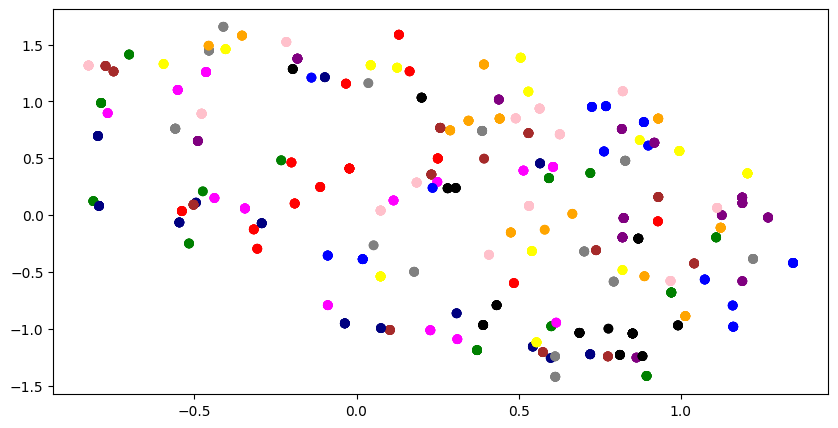

tensor([1.1117, 0.0634], device='cuda:0')
<class 'torch.Tensor'>
1.1117461919784546
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_rank1: 0.71


0.71

In [53]:
apply_framework(birds_similar_8rank2, "jpg", model1, True)

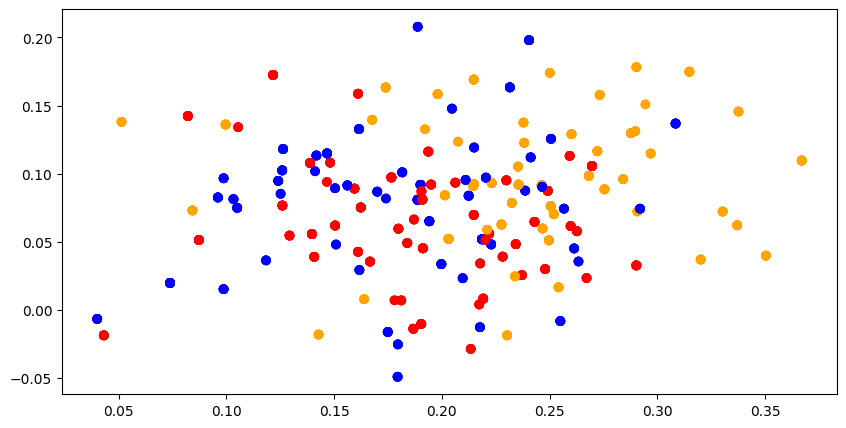

tensor([0.1798, 0.0595], device='cuda:0')
<class 'torch.Tensor'>
0.17984336614608765
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.8166666666666667


0.8166666666666667

In [47]:
apply_framework(birds_similar_8rank2, "jpg", model2, True)

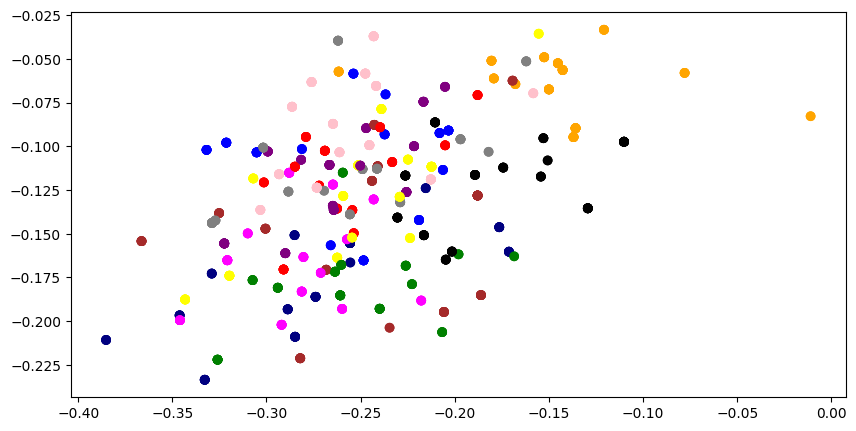

tensor([-0.2933, -0.1160], device='cuda:0')
<class 'torch.Tensor'>
-0.2933128774166107
datasets/birds-16/birds_dataset_triplets/birds_query_rank0_dissimilar: 0.8166666666666667


0.8166666666666667

In [36]:
apply_framework(birds_similar_8rank2, "jpg", model2, True)

In [ ]:
apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1", "jpg",ResNet,True)

datasets/hsj/hsj_triplets/hsj_query_rank0_rank1: 0.724


0.724

In [ ]:
print("#-------------------------------Resnet-18-------------------------------------#")
ResNet.cuda()
layer = ResNet._modules.get("Feature_Extractor")
ResNet.eval()
t = torch.rand(1,3,224,224)
ResNet()
apply_framework_model(ResNet,layer,[1, 512, 1, 1])

In [ ]:
ResNet.eval()
layer = ResNet.Feature_Extractor
apply_framework("datasets/hsj/hsj_triplets/hsj_query_rank0_rank1", "jpg", ResNet, layer, True, [1,100])

In [ ]:
ResNet._modules

OrderedDict([('Feature_Extractor',
              ResNet(
                (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (relu): ReLU(inplace=True)
                (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                (layer1): Sequential(
                  (0): BasicBlock(
                    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                    (relu): ReLU(inplace=True)
                    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  )
                  (1): Ba

In [ ]:
# Tutorial: https://discuss.pytorch.org/t/feature-extraction-in-torchvision-models-vit-b-16/148029/4
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np

from PIL import Image

ResNet.eval()
layer = ResNet._modules["Feature_Extractor"]
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
    


def get_vector(path):
  with torch.no_grad():
    p0 = Variable(normalize(to_tensor(scaler(Image.open(path).convert('RGB')))).unsqueeze(0)).cuda()

    x_p0 = model._process_input(p0)

    n = x_p0.shape[0]

    batch_class_token = model.class_token.expand(n, -1, -1)

    x_p0 = torch.cat([batch_class_token, x_p0], dim=1)

    x_p0 = encoder(x_p0)

    x_p0 = torch.flatten(x_p0[:,0])

    return x_p0


def get_image_embeddings(path, image_type, isHSJOrBirds):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_dict = dict()
    feature_tensor_dict["ref"] = []
    feature_tensor_dict["p0"] = []
    feature_tensor_dict["p1"] = []
    feature_tensor_dict["decision"] = []
    
    for image_no in range(1000):
        im_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + "." + image_type
        
        feature_tensor_dict["ref"].append(get_vector(path+"/ref/" + im_no_name))
        feature_tensor_dict["p0"].append(get_vector(path+"/p0/" + im_no_name))
        feature_tensor_dict["p1"].append(get_vector(path+"/p1/" + im_no_name))

        # now load decision
        if isHSJOrBirds:
          feature_tensor_dict["decision"].append(0)
        else: 
          decision_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + ".npy"
          decision = np.load(path+"/judge/"+decision_no_name)
          if decision[0] <= 0.5: 
                feature_tensor_dict["decision"].append(0)
          else: 
                feature_tensor_dict["decision"].append(1)
        
    return feature_tensor_dict

########################## GET MODEL PREDICTIONS
def get_predictions(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

  for image_no in range(1000):
      cosine_similarity_dict["ref_and_p0"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0)))
      cosine_similarity_dict["ref_and_p1"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0)))
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions

########################## GET MODEL ACCURACY
def get_accuracy(predictions,embeddings):
  decisions = embeddings["decision"]

  number_wrong_predictions = 0

  for image_no in range(1000):
      if predictions[image_no] != decisions[image_no]:
          number_wrong_predictions += 1
      
  accuracy = (1000 - number_wrong_predictions)/(1000)
  return accuracy

def get_average_reference_similarty_for_dataset(predictions,embeddings):
  similarities_p0_p1 = []
  similarities_p0_ref = []
  similarities_p1_ref = []
  
  cos = nn.CosineSimilarity(dim=1, eps=1e-6)

  for image_no in range(1000):
      similarities_p0_p1.append(float(cos(embeddings["p0"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0))))
      similarities_p0_ref.append(float(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0))))
      similarities_p1_ref.append(float(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0))))

  similarity = np.average(similarities_p0_p1)/(float(np.average(similarities_p0_ref)+np.average(similarities_p1_ref)))

  return similarity

def apply_framework(path, image_type,isHSJOrBirds):
  embeddings = get_image_embeddings(path, 
                                    image_type,
                                    isHSJOrBirds)
  predictions= get_predictions(embeddings)
  accuracy = get_average_reference_similarty_for_dataset(predictions, embeddings)
  print(path + ": " + str(accuracy))
  return accuracy

IndexError: ignored